In [2]:
import json
from typing import List

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import targetpad_transform
from src.fashioniq_experiment.utils import element_wise_sum_original, element_wise_sum, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search, compute_results_fiq_val
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [3]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [4]:
BLIP_PRETRAINED_PATH = '../../../models/model_base_retrieval_coco.pth'
MED_CONFIG_PATH = '../../blip_modules/med_config.json'

In [5]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../../../models/model_base_retrieval_coco.pth for text_encoder.
load checkpoint from ../../../models/model_base_retrieval_coco.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [6]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH)
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder.eval()

load checkpoint from ../../../models/model_base_retrieval_coco.pth for visual_encoder.
load checkpoint from ../../../models/model_base_retrieval_coco.pth for vision_proj.


blip img encoder loaded.

BLIPImgEncoder(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [7]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [8]:
combining_function_original = element_wise_sum_original

In [9]:
combining_function = lambda image_features, text_features: element_wise_sum(image_features, text_features, alpha=0.65)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [10]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [11]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search(
        'shirt',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [12]:
display(shirt_recall_at10, shirt_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20       0.25       0.30  \
beta                                                                            
0.00   7.556428  7.801767  7.801767  7.850834  7.948969   8.145241   8.243376   
0.05   7.654563  7.850834  8.047105  7.998037  8.047105   8.096173   8.194308   
0.10   7.801767  7.948969  7.998037  8.145241  8.341511   8.635917   8.734053   
0.15   7.703631  7.899902  8.096173  8.292443  8.488715   8.783121   9.126595   
0.20   7.605495  7.850834  8.096173  8.243376  8.390579   8.684985   9.028459   
0.25   7.507360  7.703631  7.998037  8.488715  8.734053   9.322865   9.813543   
0.30   7.703631  7.998037  8.341511  8.684985  8.930324   9.666339  10.009813   
0.35   7.703631  7.948969  8.390579  8.684985  9.126595   9.568204  10.157017   
0.40   7.752699  8.243376  8.684985  9.028459  9.421001   9.960746  10.500491   
0.45   7.605495  7.998037  8.488715  9.077527  9.421001  10.157017  10.745829   
0.50   7.654563  8.243376  8.586850  8.979391  9.519137  10.206085  11.432777   
0.55   7.458293  7.899902  8.439647  9.028459  9.322865  10.402355  11.432777   
0.60   7.114819  7.654563  8.096173  8.881256  9.371933  10.549559  11.629048   
0.65   6.673209  7.311089  7.752699  8.439647  9.224730  10.647694  11.579981   
0.70   6.427871  6.869480  7.507360  8.145241  9.126595  10.255152  11.383709   
0.75   6.329735  6.624141  7.311089  8.194308  8.783121   9.813543  11.138371   
0.80   6.133464  6.526006  6.918547  7.507360  8.635917   9.715407  11.138371   
0.85   5.888126  6.182532  6.918547  7.703631  8.586850   9.715407  11.089303   
0.90   5.495584  5.937193  6.329735  7.016683  8.047105   9.175663  10.549559   
0.95   5.397448  5.839058  6.280667  6.673209  7.507360   8.684985   9.764475   
1.00   5.397448  5.691855  6.035329  6.526006  7.163886   8.341511   9.077527   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00    8.292443   8.439647   8.586850  ...   9.322865   9.666339  10.255152   
0.05    8.586850   8.881256   8.979391  ...   9.862611  10.402355  11.285574   
0.10    8.979391   9.371933   9.666339  ...  10.500491  11.236507  11.923455   
0.15    9.273798   9.519137   9.862611  ...  11.285574  12.021590  12.904808   
0.20    9.568204  10.107949  10.549559  ...  11.874387  12.904808  14.229637   
0.25   10.157017  10.745829  11.285574  ...  13.002944  14.278704  15.407263   
0.30   10.598626  11.187439  11.874387  ...  14.474976  15.407263  16.094211   
0.35   11.040235  11.825319  13.002944  ...  15.309127  15.996075  17.173700   
0.40   11.285574  12.561335  13.395485  ...  15.947007  16.486752  18.204121   
0.45   11.825319  12.953876  14.033367  ...  16.339548  17.860648  19.087340   
0.50   12.168793  13.199215  14.474976  ...  17.320903  18.449460  20.117763   
0.55   12.168793  13.542689  14.720315  ...  18.105987  19.381747  20.804711   
0.60   12.610403  13.444553  14.818449  ...  18.547596  19.921492  21.982336   
0.65   12.659471  13.689892  15.358195  ...  18.498528  20.755643  22.767419   
0.70   12.757605  14.033367  15.309127  ...  18.940137  21.540727  22.963689   
0.75   12.659471  13.984299  15.210991  ...  19.185476  21.884200  23.503435   
0.80   12.315996  13.984299  15.603533  ...  19.283612  21.982336  23.454367   
0.85   12.070657  13.640824  15.505397  ...  19.578017  21.933268  22.669284   
0.90   12.168793  13.591756  15.309127  ...  18.989205  21.197252  22.571148   
0.95   11.530913  13.395485  14.965652  ...  19.087340  20.559372  21.393523   
1.00   10.647694  12.708537  14.671247  ...  18.596664  20.363101  20.951913   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   11.138371  12.266929  14.622179  16.977429  22.620216  29.685965   
0.05   12.217861  13.444553  15.554465  18.743867  24.288519  29.98037

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   17.762512  17.811580  18.007851  18.155053  18.351325  18.449460   
0.05   18.056919  18.204121  18.498528  18.596664  18.792935  19.087340   
0.10   18.400392  18.498528  18.891069  19.185476  19.234544  19.578017   
0.15   18.940137  19.381747  19.479883  19.774288  19.970560  20.657508   
0.20   18.940137  19.185476  19.725221  20.215897  20.706575  21.295388   
0.25   19.038273  19.430815  20.019627  20.706575  21.197252  21.933268   
0.30   18.596664  19.381747  20.264965  20.902845  21.687929  22.669284   
0.35   18.253189  19.038273  20.166831  21.099117  21.884200  22.963689   
0.40   17.664377  18.449460  19.528949  20.755643  21.786065  22.865555   
0.45   17.419039  18.155053  19.283612  20.706575  21.687929  23.061825   
0.50   17.075564  17.909716  19.283612  20.510304  21.638861  23.012757   
0.55   17.124632  17.713444  19.087340  20.166831  21.393523  22.767419   
0.60   16.732091  17.566241  18.743867  19.823356  20.951913  22.865555   
0.65   16.339548  17.222768  18.105987  19.381747  20.657508  22.865555   
0.70   15.652600  16.633955  17.713444  19.038273  20.412169  22.423945   
0.75   15.210991  16.143277  17.468105  18.645731  20.068695  21.589793   
0.80   14.720315  15.554465  16.879293  18.204121  19.725221  21.197252   
0.85   14.082433  15.063788  16.339548  17.517173  19.038273  20.951913   
0.90   13.346419  14.327772  15.407263  16.535820  18.449460  20.215897   
0.95   12.561335  13.640824  14.769381  15.848872  17.320903  19.725221   
1.00   12.021590  12.953876  13.640824  14.818449  16.535820  18.694799   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   18.645731  18.792935  18.940137  19.479883  ...  20.559372  21.246320   
0.05   19.332679  19.725221  19.970560  20.461236  ...  21.540727  22.571148   
0.10   20.117763  20.608440  21.050049  21.540727  ...  22.816487  23.797841   
0.15   21.246320  21.491659  22.178607  22.325809  ...  24.092247  25.024533   
0.20   21.786065  22.129539  22.865555  23.552503  ...  24.877331  26.005888   
0.25   22.620216  23.061825  23.552503  24.337585  ...  26.005888  27.281648   
0.30   23.012757  23.650637  24.386653  25.171736  ...  27.183512  28.900883   
0.35   23.503435  24.337585  25.368008  26.202160  ...  28.851816  30.471051   
0.40   23.994112  25.073603  26.054955  27.036309  ...  29.980373  32.384691   
0.45   24.190383  25.368008  26.594701  27.968597  ...  31.059861  33.366045   
0.50   24.484789  25.711483  26.938176  28.851816  ...  32.433757  35.083416   
0.55   24.092247  26.005888  27.232581  30.078509  ...  33.954859  36.653581   
0.60   24.337585  26.153091  28.213936  30.618253  ...  34.936211  37.684003   
0.65   24.386653  26.349363  28.361139  31.157997  ...  36.162904  37.831208   
0.70   24.288519  26.300293  28.557408  31.207067  ...  36.064771  38.518155   
0.75   23.503435  25.711483  28.459275  31.452405  ...  36.800784  39.205104   
0.80   22.914623  25.417075  28.312069  31.305200  ...  37.046123  39.597645   
0.85   22.571148  24.484789  27.674189  30.961728  ...  36.947989  38.861629   
0.90   21.589793  24.435721  27.281648  30.225712  ...  36.898920  38.321885   
0.95   21.344456  24.141315  26.594701  29.882237  ...  36.457312  37.095192   
1.00   21.099117  23.650637  26.349363  28.949952  ...  35.034347  35.966635   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   22.276741  23.650637  25.024533  27.674189  32.531893  39.842984   
0.05   23.797841  24.730128  26.594701  29.195291  35.034347  41.658488   
0.10   24.730128  26.447499  28.017664  31.010795  36.702651  43.130520   
0.15   26.251227  27.625123  29.784101  33.218843  38.5672

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [13]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search(
        'dress',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [14]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   5.057015  5.057015  5.156172  5.354487  5.404066  5.503223  5.552801   
0.05   5.106594  5.156172  5.205751  5.255330  5.255330  5.354487  5.651958   
0.10   5.205751  5.205751  5.255330  5.503223  5.602380  5.651958  5.899851   
0.15   5.156172  5.255330  5.354487  5.404066  5.602380  5.899851  6.098166   
0.20   4.858701  5.007437  5.304908  5.503223  5.602380  5.751115  6.098166   
0.25   4.660387  4.660387  4.759544  4.858701  5.205751  5.404066  5.701537   
0.30   4.511651  4.610808  4.660387  4.709965  4.809123  5.007437  5.552801   
0.35   4.263758  4.313337  4.511651  4.709965  4.809123  5.106594  5.404066   
0.40   3.916708  4.065444  4.164601  4.462072  4.709965  5.156172  5.304908   
0.45   3.470501  3.569658  3.867129  4.164601  4.412494  4.709965  5.057015   
0.50   3.371344  3.420922  3.718394  3.767972  4.164601  4.412494  4.759544   
0.55   3.272187  3.222608  3.420922  3.668815  3.817551  4.214180  4.709965   
0.60   3.024293  3.073872  3.222608  3.520079  3.767972  4.015865  4.462072   
0.65   2.578086  2.875558  3.123451  3.420922  3.718394  3.916708  4.263758   
0.70   2.528508  2.677243  2.726822  3.024293  3.321765  3.619236  3.966286   
0.75   2.528508  2.578086  2.677243  2.825979  3.173029  3.470501  4.015865   
0.80   2.528508  2.528508  2.726822  2.726822  2.925136  3.420922  3.867129   
0.85   2.429350  2.330193  2.578086  2.627665  2.776401  3.222608  3.718394   
0.90   2.231036  2.181458  2.429350  2.528508  2.726822  2.974715  3.569658   
0.95   2.082300  2.131879  2.280615  2.478929  2.677243  3.073872  3.420922   
1.00   1.834407  1.784829  1.933565  2.181458  2.379772  2.726822  3.420922   

alpha      0.35      0.40      0.45  ...       0.55       0.60       0.65  \
beta                                 ...                                    
0.00   5.701537  5.949430  6.048587  ...   6.544373   6.891423   7.188895   
0.05   5.850273  6.147744  6.296480  ...   6.990580   7.337630   7.882994   
0.10   6.048587  6.395637  6.693108  ...   7.288051   7.684680   8.477937   
0.15   6.346059  6.445216  6.792266  ...   7.337630   8.031730   8.775409   
0.20   6.246901  6.593952  6.792266  ...   7.734258   8.428359   9.469509   
0.25   5.899851  6.346059  6.643530  ...   7.833416   9.172038   9.816559   
0.30   5.800694  6.246901  6.792266  ...   8.329201   9.320773  10.956866   
0.35   5.651958  6.296480  6.593952  ...   8.725830   9.618245  11.254338   
0.40   5.651958  6.147744  7.089737  ...   9.072880  10.163610  11.700545   
0.45   5.552801  6.197323  6.792266  ...   9.370352  10.758552  12.196331   
0.50   5.354487  6.246901  6.891423  ...   9.568667  11.006445  12.791274   
0.55   5.057015  6.098166  7.040159  ...   9.766981  11.254338  13.237481   
0.60   5.007437  5.899851  7.089737  ...  10.064452  11.700545  13.088746   
0.65   4.858701  5.751115  7.089737  ...  10.163610  11.898860  13.336639   
0.70   4.759544  5.453644  6.792266  ...  10.064452  11.700545  13.138324   
0.75   4.858701  5.552801  6.990580  ...   9.915716  11.204760  12.692118   
0.80   4.462072  5.404066  6.693108  ...  10.114031  10.956866  12.394646   
0.85   4.412494  5.354487  6.494794  ...   9.469509  10.758552  12.295488   
0.90   4.164601  5.205751  6.445216  ...   8.824988  10.163610  11.551809   
0.95   3.966286  5.007437  5.899851  ...   8.378781   9.915716  10.758552   
1.00   3.718394  4.511651  5.751115  ...   8.130887   9.221616   9.965295   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    7.932573   8.775409  10.708974  13.733268  19.038175  23.847298   
0.05    8.477937   9.519088  11.799703  14.675260  20.327219  24.739712   
0.10    9.172038  10.064452  12.642539  15.964304  21.021318  25.731283   
0.15    9.915716  11.204760  13.634

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   12.047596  12.146752  12.444224  12.592959  12.890431  12.989588   
0.05   12.295488  12.493803  12.692118  12.890431  13.138324  13.187903   
0.10   12.245910  12.345067  12.692118  13.039167  13.237481  13.534953   
0.15   12.097174  12.543382  12.741695  13.187903  13.386217  13.782845   
0.20   11.799703  11.998017  12.394646  12.989588  13.386217  13.931581   
0.25   11.750124  12.047596  12.345067  13.039167  13.386217  14.129896   
0.30   11.403074  11.700545  12.245910  12.543382  13.138324  14.030738   
0.35   11.601388  11.700545  12.047596  12.345067  13.138324  13.782845   
0.40   11.056024  11.502231  11.799703  12.245910  13.088746  13.882002   
0.45   10.857709  11.353495  11.799703  12.394646  12.940010  14.030738   
0.50   10.411502  10.956866  11.551809  12.295488  13.187903  13.882002   
0.55   10.064452  10.808131  11.403074  11.998017  12.940010  13.634109   
0.60    9.419931   9.915716  10.808131  11.601388  12.444224  13.287060   
0.65    9.023302   9.766981  10.411502  11.006445  11.998017  13.138324   
0.70    8.874566   9.618245  10.312345  10.609817  11.551809  12.543382   
0.75    8.428359   8.973724   9.766981  10.262766  11.056024  12.146752   
0.80    7.783838   8.378781   9.271195   9.816559  10.510659  11.452653   
0.85    7.387209   7.932573   8.527516   9.271195  10.163610  11.353495   
0.90    6.941001   7.535944   8.180466   8.874566   9.568667  10.808131   
0.95    6.593952   6.990580   7.684680   8.279623   9.370352  10.560238   
1.00    6.593952   6.742688   7.337630   7.783838   8.477937   9.866138   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   13.336639  13.485375  13.782845  14.179474  ...  14.972731  15.815568   
0.05   13.584532  14.278631  14.675260  14.923154  ...  15.666832  16.807139   
0.10   13.882002  14.625682  14.972731  15.270203  ...  16.856718  17.997025   
0.15   14.179474  14.774418  15.567675  16.410510  ...  17.947447  19.434804   
0.20   14.923154  15.369360  16.063461  17.104611  ...  19.186911  20.872582   
0.25   14.823996  15.666832  16.509669  17.550819  ...  20.327219  21.814576   
0.30   15.171047  16.013882  16.955875  18.096182  ...  21.070898  22.756569   
0.35   14.972731  15.914725  17.550819  18.839861  ...  22.062469  23.996034   
0.40   14.972731  16.212197  17.798711  19.434804  ...  22.806148  25.384235   
0.45   15.121467  16.757561  18.195340  19.881012  ...  23.996034  26.227069   
0.50   15.319782  17.203768  18.344076  19.732276  ...  24.789292  27.119485   
0.55   14.923154  16.856718  18.046604  19.732276  ...  25.037184  27.664849   
0.60   14.873575  16.162618  18.096182  19.881012  ...  25.136340  27.962321   
0.65   14.476946  15.865146  17.749132  20.327219  ...  25.235498  27.962321   
0.70   14.229053  15.765989  17.253347  20.228061  ...  25.185919  27.714428   
0.75   13.832425  15.567675  17.055032  19.533962  ...  24.938026  27.516112   
0.80   13.187903  14.923154  16.955875  19.385226  ...  24.640556  27.218643   
0.85   12.940010  14.229053  15.815568  18.988597  ...  24.045612  26.623699   
0.90   12.047596  13.683689  15.319782  18.145761  ...  23.301934  25.384235   
0.95   11.551809  12.791274  14.774418  17.005454  ...  22.558255  24.590977   
1.00   10.956866  11.948438  13.634109  16.707982  ...  21.764998  23.004462   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   17.104611  18.691126  20.773426  24.194348  29.995042  37.481409   
0.05   18.344076  20.178483  22.459097  25.830442  32.374814  38.770452   
0.10   19.533962  21.715419  23.896876  27.466536  34.506693  40.456122   
0.15   21.417947  23.202777  25.582549  29.598415  35.8948

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [15]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search(
        'toptee',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [16]:
display(toptee_recall_at10, toptee_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   7.547170  7.598164  7.649159  7.649159  7.700153  7.751147  7.853136   
0.05   7.241204  7.292198  7.445181  7.649159  7.700153  7.904130  8.057114   
0.10   7.088220  7.190209  7.394186  7.394186  7.649159  7.853136  8.057114   
0.15   6.680265  6.731260  7.088220  7.343192  7.547170  7.853136  8.006119   
0.20   6.680265  6.833249  6.884243  7.292198  7.445181  7.700153  8.210097   
0.25   6.425294  6.527282  6.884243  7.088220  7.445181  7.751147  8.108108   
0.30   6.221316  6.476288  6.680265  7.241204  7.598164  7.904130  8.414075   
0.35   5.915349  6.170321  6.476288  6.986231  7.496175  8.108108  8.516064   
0.40   5.507394  5.864355  6.272310  6.833249  7.190209  7.802141  8.669046   
0.45   5.405406  5.609383  6.068332  6.680265  7.241204  7.751147  8.669046   
0.50   5.405406  5.762366  6.068332  6.476288  6.986231  7.751147  8.669046   
0.55   5.354411  5.711372  6.017338  6.476288  7.088220  7.802141  9.280979   
0.60   5.150434  5.456400  5.864355  6.272310  7.037226  7.802141  9.127996   
0.65   4.793473  5.201428  5.405406  5.864355  6.629271  7.802141  9.077001   
0.70   4.334523  4.691484  5.048444  5.762366  6.527282  7.751147  8.618052   
0.75   4.130546  4.334523  4.946456  5.507394  6.272310  7.445181  8.465069   
0.80   3.977562  4.079551  4.793473  5.405406  6.272310  7.037226  8.159102   
0.85   3.773585  4.181540  4.895461  5.354411  5.966344  6.731260  7.955125   
0.90   3.620602  4.028557  4.640489  5.048444  5.915349  6.476288  7.598164   
0.95   3.365630  3.926568  4.487506  4.793473  5.558389  6.323305  7.598164   
1.00   3.110658  3.569607  4.232534  4.640489  5.405406  6.272310  7.190209   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00    8.006119   7.955125   8.210097  ...   8.771035   9.229985   9.943906   
0.05    8.057114   8.108108   8.465069  ...   9.280979   9.892911  10.504845   
0.10    8.057114   8.465069   8.822030  ...   9.943906  10.606834  11.728710   
0.15    8.414075   8.771035   9.280979  ...  10.606834  11.728710  13.105558   
0.20    8.669046   9.280979   9.637940  ...  11.626721  12.595615  14.329425   
0.25    8.669046   9.484956  10.249873  ...  12.595615  13.972463  16.012238   
0.30    9.178990   9.892911  10.861805  ...  13.615502  15.145335  17.032127   
0.35    9.280979  10.045895  11.779704  ...  14.635390  16.471188  18.918920   
0.40    9.229985  10.453850  12.136665  ...  15.859255  17.695053  20.091790   
0.45    9.637940  11.167771  12.901580  ...  16.930138  18.918920  21.519633   
0.50   10.300867  11.932687  13.564508  ...  17.899030  20.091790  22.080570   
0.55   10.504845  12.187659  14.278430  ...  18.969913  20.907700  23.202448   
0.60   10.555839  12.238654  14.635390  ...  19.479857  21.570627  24.018358   
0.65   10.504845  12.697603  14.992350  ...  19.836818  22.233555  25.293219   
0.70   10.096889  12.442631  15.145335  ...  20.397756  22.794493  26.160121   
0.75    9.841917  12.034676  14.533402  ...  20.499745  23.049465  25.446200   
0.80    9.586945  12.034676  14.686385  ...  20.652728  22.896482  24.936257   
0.85    9.382968  12.136665  14.992350  ...  20.091790  22.590515  24.018358   
0.90    9.280979  11.932687  14.737380  ...  19.887812  21.978582  23.100460   
0.95    9.229985  11.626721  14.278430  ...  19.122897  20.856705  21.978582   
1.00    8.924019  11.065783  14.074452  ...  18.103008  19.887812  21.315655   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   10.555839  11.983681  14.992350  18.918920  25.752166  32.840389   
0.05   11.677715  13.258542  16.471188  20.958695  27.434981  33.401325   
0.10   13.207547  15.196328  18.765935  2

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   16.624172  16.624172  16.726160  16.828150  16.981132  17.083120   
0.05   16.369200  16.573177  16.624172  16.828150  17.185110  17.440082   
0.10   16.318205  16.777155  16.981132  17.593065  17.950025  18.306985   
0.15   16.216215  16.879143  17.185110  17.695053  18.204997  19.173890   
0.20   16.012238  16.471188  17.338093  17.848037  18.612953  19.377868   
0.25   15.706272  16.369200  17.185110  17.848037  18.867925  19.632840   
0.30   15.502295  16.216215  16.675165  18.001020  19.122897  20.193778   
0.35   14.992350  15.706272  16.573177  17.899030  18.969913  20.040795   
0.40   14.533402  15.655278  16.369200  17.440082  18.663947  20.040795   
0.45   14.125445  14.992350  16.063233  16.981132  18.103008  19.938807   
0.50   13.717490  14.584395  15.451300  16.624172  17.644060  19.479857   
0.55   13.207547  14.125445  15.145335  16.318205  17.746048  19.377868   
0.60   12.748598  13.462520  14.380418  16.165222  17.695053  19.173890   
0.65   12.595615  13.003570  13.921468  15.349312  17.185110  19.173890   
0.70   12.034676  12.595615  13.564508  14.788373  16.675165  18.663947   
0.75   11.626721  12.238654  13.309535  14.329425  16.114227  17.899030   
0.80   10.912800  11.779704  13.054565  13.819480  15.655278  17.236105   
0.85   10.300867  11.014789  12.187659  13.360530  14.890362  17.134115   
0.90    9.637940  10.606834  11.626721  12.646610  14.380418  16.522183   
0.95    9.637940  10.351861  11.320755  12.187659  14.023457  16.063233   
1.00    9.331974  10.045895  10.657828  11.728710  13.564508  15.604283   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   17.134115  17.389087  17.797042  18.357980  ...  19.581845  21.009690   
0.05   18.052015  18.306985  18.765935  19.581845  ...  21.264660  22.590515   
0.10   18.918920  19.326875  20.142785  20.958695  ...  22.845487  24.324325   
0.15   19.581845  20.091790  20.958695  22.182560  ...  24.630290  26.415095   
0.20   20.040795  20.958695  22.182560  23.049465  ...  26.466089  28.454870   
0.25   20.958695  21.927588  23.151453  24.579297  ...  28.454870  30.239674   
0.30   21.264660  22.386537  23.712392  25.650179  ...  29.525751  31.718510   
0.35   21.060683  23.100460  24.885263  27.282000  ...  31.463540  33.962265   
0.40   21.570627  23.610403  25.650179  28.250891  ...  33.401325  35.849056   
0.45   21.468638  24.018358  26.364100  29.015809  ...  34.523201  37.837839   
0.50   21.621622  24.120347  26.670066  29.882714  ...  36.104029  38.806731   
0.55   21.468638  24.120347  26.976034  30.545640  ...  37.225905  40.591535   
0.60   21.417645  24.426313  27.842936  31.310555  ...  37.990820  41.560429   
0.65   21.162672  24.732280  28.454870  32.024476  ...  39.316675  42.580315   
0.70   21.111678  24.273330  28.454870  32.330444  ...  40.030596  42.478326   
0.75   20.958695  24.273330  28.403875  32.279450  ...  39.775625  42.478326   
0.80   20.856705  24.171340  27.689955  32.177460  ...  39.469659  42.121366   
0.85   20.091790  23.457420  27.383989  32.024476  ...  39.112699  41.407445   
0.90   19.530852  22.896482  26.670066  30.647629  ...  38.704741  41.305456   
0.95   18.918920  22.182560  26.007140  29.933706  ...  38.500765  40.540540   
1.00   18.510965  21.264660  25.038245  29.321775  ...  37.327895  39.265680   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   22.284548  23.916370  26.262110  30.086690  35.492095  43.702194   
0.05   23.712392  26.058134  29.270780  32.432431  37.684855  45.945945   
0.10   26.109129  29.372770  31.004590  34.676185  39.928609  48.138705   
0.15   28.505865  30.851606  33.350331  36.817950  42.3763

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [17]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [18]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.720204  6.818982  6.869033  6.951493  7.017729  7.133204  7.216438   
0.05   6.667454  6.766401  6.899346  6.967509  7.000863  7.118263  7.301127   
0.10   6.698579  6.781643  6.882518  7.014217  7.197683  7.380337  7.563673   
0.15   6.513356  6.628830  6.846293  7.013234  7.212755  7.512036  7.743626   
0.20   6.381487  6.563840  6.761775  7.012932  7.146047  7.378751  7.778907   
0.25   6.197680  6.297100  6.547275  6.811879  7.128328  7.492693  7.874396   
0.30   6.145533  6.361711  6.560721  6.878718  7.112537  7.525969  7.992230   
0.35   5.960913  6.144209  6.459506  6.793727  7.143964  7.594302  8.025715   
0.40   5.725600  6.057725  6.373965  6.774593  7.107058  7.639687  8.158148   
0.45   5.493800  5.725693  6.141392  6.640797  7.024899  7.539376  8.157297   
0.50   5.477104  5.808888  6.124525  6.407884  6.889990  7.456575  8.287122   
0.55   5.361630  5.611294  5.959302  6.391187  6.742879  7.472892  8.474574   
0.60   5.096515  5.394945  5.727712  6.224548  6.725711  7.455855  8.406372   
0.65   4.681589  5.129358  5.427185  5.908308  6.524132  7.455514  8.306913   
0.70   4.430300  4.746069  5.094209  5.643967  6.325214  7.208512  7.989349   
0.75   4.329596  4.512250  4.978263  5.509227  6.076153  6.909741  7.873102   
0.80   4.213178  4.378022  4.812947  5.213196  5.944455  6.724519  7.721534   
0.85   4.030354  4.231422  4.797365  5.228569  5.776531  6.556425  7.587607   
0.90   3.782407  4.049069  4.466525  4.864545  5.563092  6.208888  7.239127   
0.95   3.615126  3.965835  4.349596  4.648537  5.247664  6.027387  6.927854   
1.00   3.447505  3.682097  4.067143  4.449318  4.983021  5.780214  6.562886   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   7.333366   7.448067   7.615178  ...   8.212758   8.595916   9.129318   
0.05   7.498079   7.712369   7.913647  ...   8.711390   9.210966   9.891138   
0.10   7.695031   8.077546   8.393826  ...   9.244149   9.842673  10.710034   
0.15   8.011311   8.245129   8.645285  ...   9.743346  10.594010  11.595258   
0.20   8.161384   8.660960   8.993255  ...  10.411789  11.309594  12.676190   
0.25   8.241971   8.858948   9.392992  ...  11.143992  12.474402  13.745353   
0.30   8.526103   9.109084   9.842819  ...  12.139893  13.291124  14.694401   
0.35   8.657724   9.389231  10.458867  ...  12.890116  14.028503  15.782319   
0.40   8.722506   9.720976  10.873962  ...  13.626381  14.781805  16.665486   
0.45   9.005353  10.106323  11.242404  ...  14.213346  15.846040  17.601101   
0.50   9.274716  10.459601  11.643635  ...  14.929533  16.515898  18.329869   
0.55   9.243551  10.609505  12.012968  ...  15.614294  17.181262  19.081546   
0.60   9.391226  10.527686  12.181192  ...  16.030635  17.730888  19.696480   
0.65   9.341005  10.712870  12.480094  ...  16.166318  18.296019  20.465759   
0.70   9.204679  10.643214  12.415576  ...  16.467448  18.678588  20.754045   
0.75   9.120030  10.523925  12.244991  ...  16.533646  18.712808  20.547251   
0.80   8.788338  10.474347  12.327676  ...  16.683457  18.611895  20.261757   
0.85   8.622040  10.377325  12.330847  ...  16.379772  18.427445  19.661043   
0.90   8.538124  10.243398  12.163907  ...  15.900669  17.779815  19.074472   
0.95   8.242395  10.009881  11.714644  ...  15.529673  17.110598  18.043552   
1.00   7.763369   9.428657  11.498938  ...  14.943520  16.490843  17.410955   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    9.875594  11.008673  13.441168  16.543206  22.470186  28.791218   
0.05   10.791171  12.074061  14.608452  18.125940  24.016906  29.373804   
0.10   11.810532  13.294320  16.046855  19.379539  25.535293  29

In [19]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   15.478093  15.527501  15.726078  15.858721  16.074296  16.174056   
0.05   15.573869  15.757034  15.938273  16.105082  16.372123  16.571775   
0.10   15.654836  15.873583  16.188106  16.605903  16.807350  17.139985   
0.15   15.751176  16.268090  16.468896  16.885748  17.187258  17.871415   
0.20   15.584026  15.884894  16.485987  17.017841  17.568581  18.201612   
0.25   15.498223  15.949203  16.516601  17.197926  17.817131  18.565335   
0.30   15.167344  15.766169  16.395347  17.149082  17.983050  18.964600   
0.35   14.948976  15.481697  16.262535  17.114405  17.997479  18.929110   
0.40   14.417934  15.202323  15.899284  16.813878  17.846253  18.929451   
0.45   14.134065  14.833633  15.715516  16.694118  17.576983  19.010457   
0.50   13.734852  14.483659  15.428907  16.476655  17.490275  18.791539   
0.55   13.465544  14.215674  15.211916  16.161018  17.359860  18.593132   
0.60   12.966873  13.648159  14.644139  15.863322  17.030397  18.442168   
0.65   12.652822  13.331106  14.146319  15.245835  16.613545  18.392590   
0.70   12.187281  12.949272  13.863432  14.812154  16.213048  17.877091   
0.75   11.755357  12.451885  13.514874  14.412641  15.746315  17.211859   
0.80   11.138984  11.904317  13.068351  13.946720  15.297053  16.628670   
0.85   10.590170  11.337050  12.351574  13.382966  14.697415  16.479841   
0.90    9.975120  10.823517  11.738150  12.685665  14.132848  15.848737   
0.95    9.597742  10.327755  11.258272  12.105385  13.571571  15.449564   
1.00    9.315838   9.914153  10.545427  11.443666  12.859422  14.721740   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   16.372162  16.555799  16.840008  17.339112  ...  18.371316  19.357193   
0.05   16.989742  17.436946  17.803918  18.322078  ...  19.490740  20.656267   
0.10   17.639561  18.186999  18.721855  19.256542  ...  20.839564  22.039730   
0.15   18.335880  18.785956  19.568326  20.306293  ...  22.223328  23.624811   
0.20   18.916671  19.485865  20.370525  21.235526  ...  23.510110  25.111113   
0.25   19.467635  20.218748  21.071208  22.155900  ...  24.929326  26.445299   
0.30   19.816155  20.683685  21.684973  22.972699  ...  25.926720  27.791987   
0.35   19.845616  21.117590  22.601363  24.108007  ...  27.459275  29.476450   
0.40   20.179157  21.632067  23.167948  24.907335  ...  28.729282  31.205994   
0.45   20.260163  22.047976  23.718047  25.621806  ...  29.859699  32.476984   
0.50   20.475398  22.345199  23.984106  26.155602  ...  31.109026  33.669877   
0.55   20.161346  22.327651  24.085073  26.785475  ...  32.072649  34.969988   
0.60   20.209602  22.247340  24.717685  27.269940  ...  32.687790  35.735584   
0.65   20.008757  22.315596  24.855047  27.836564  ...  33.571692  36.124615   
0.70   19.876417  22.113204  24.755208  27.921857  ...  33.760428  36.236970   
0.75   19.431518  21.850829  24.639394  27.755272  ...  33.838145  36.399847   
0.80   18.986410  21.503856  24.319300  27.622629  ...  33.718779  36.312551   
0.85   18.534316  20.723754  23.624582  27.324934  ...  33.368767  35.630925   
0.90   17.722747  20.338631  23.090499  26.339701  ...  32.968532  35.003859   
0.95   17.271728  19.705050  22.458753  25.607132  ...  32.505444  34.075570   
1.00   16.855649  18.954579  21.673906  24.993236  ...  31.375746  32.745592   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   20.555300  22.086044  24.020023  27.318409  32.673010  40.342196   
0.05   21.951436  23.655582  26.108193  29.152721  35.031339  42.124962   
0.10   23.457740  25.845229  27.639710  31.051172  37.045984  43.908449   
0.15   25.391680  27.226502  29.572327  33.211736  38.9461

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [20]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

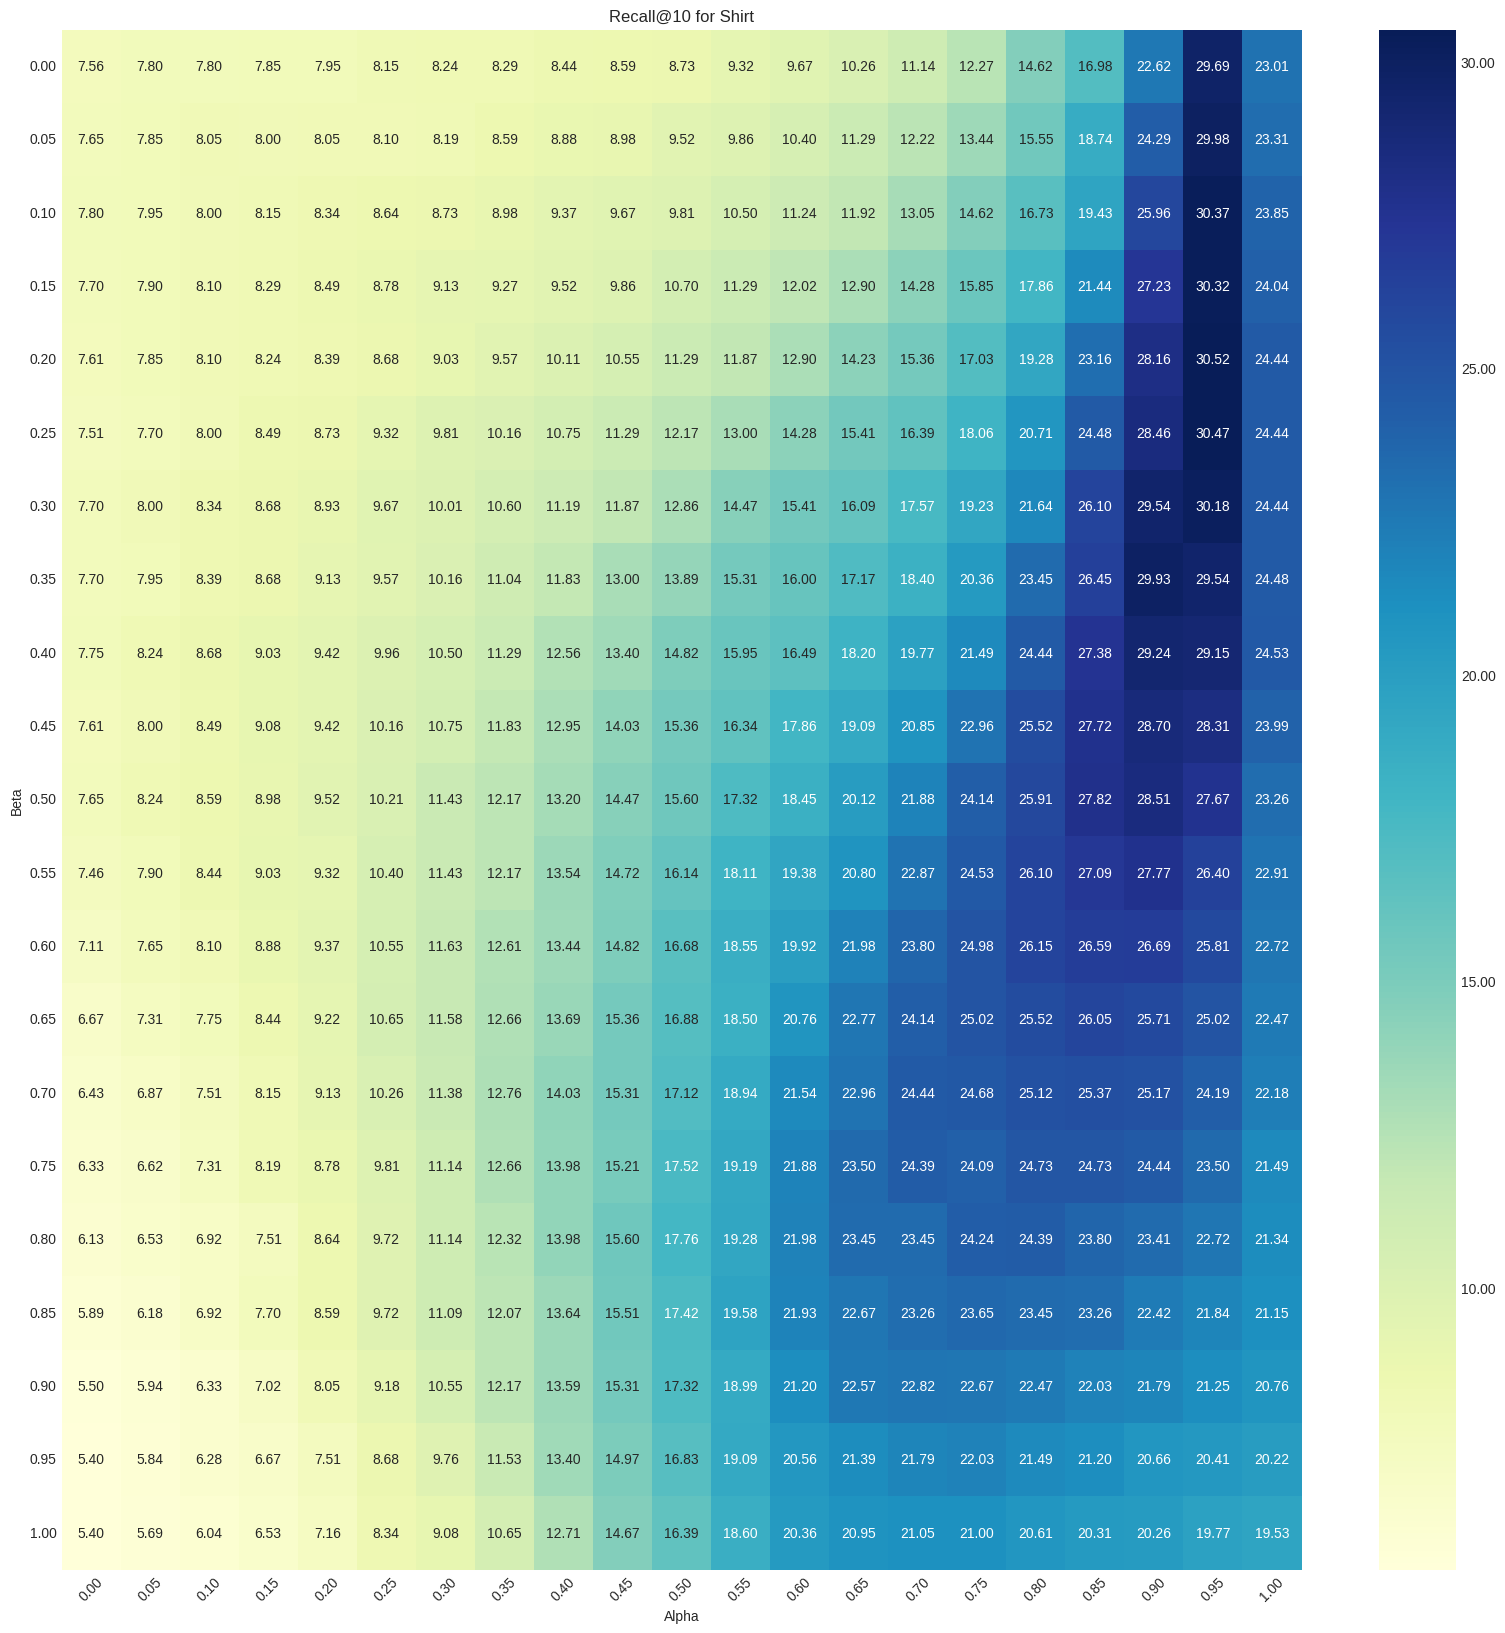

In [21]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

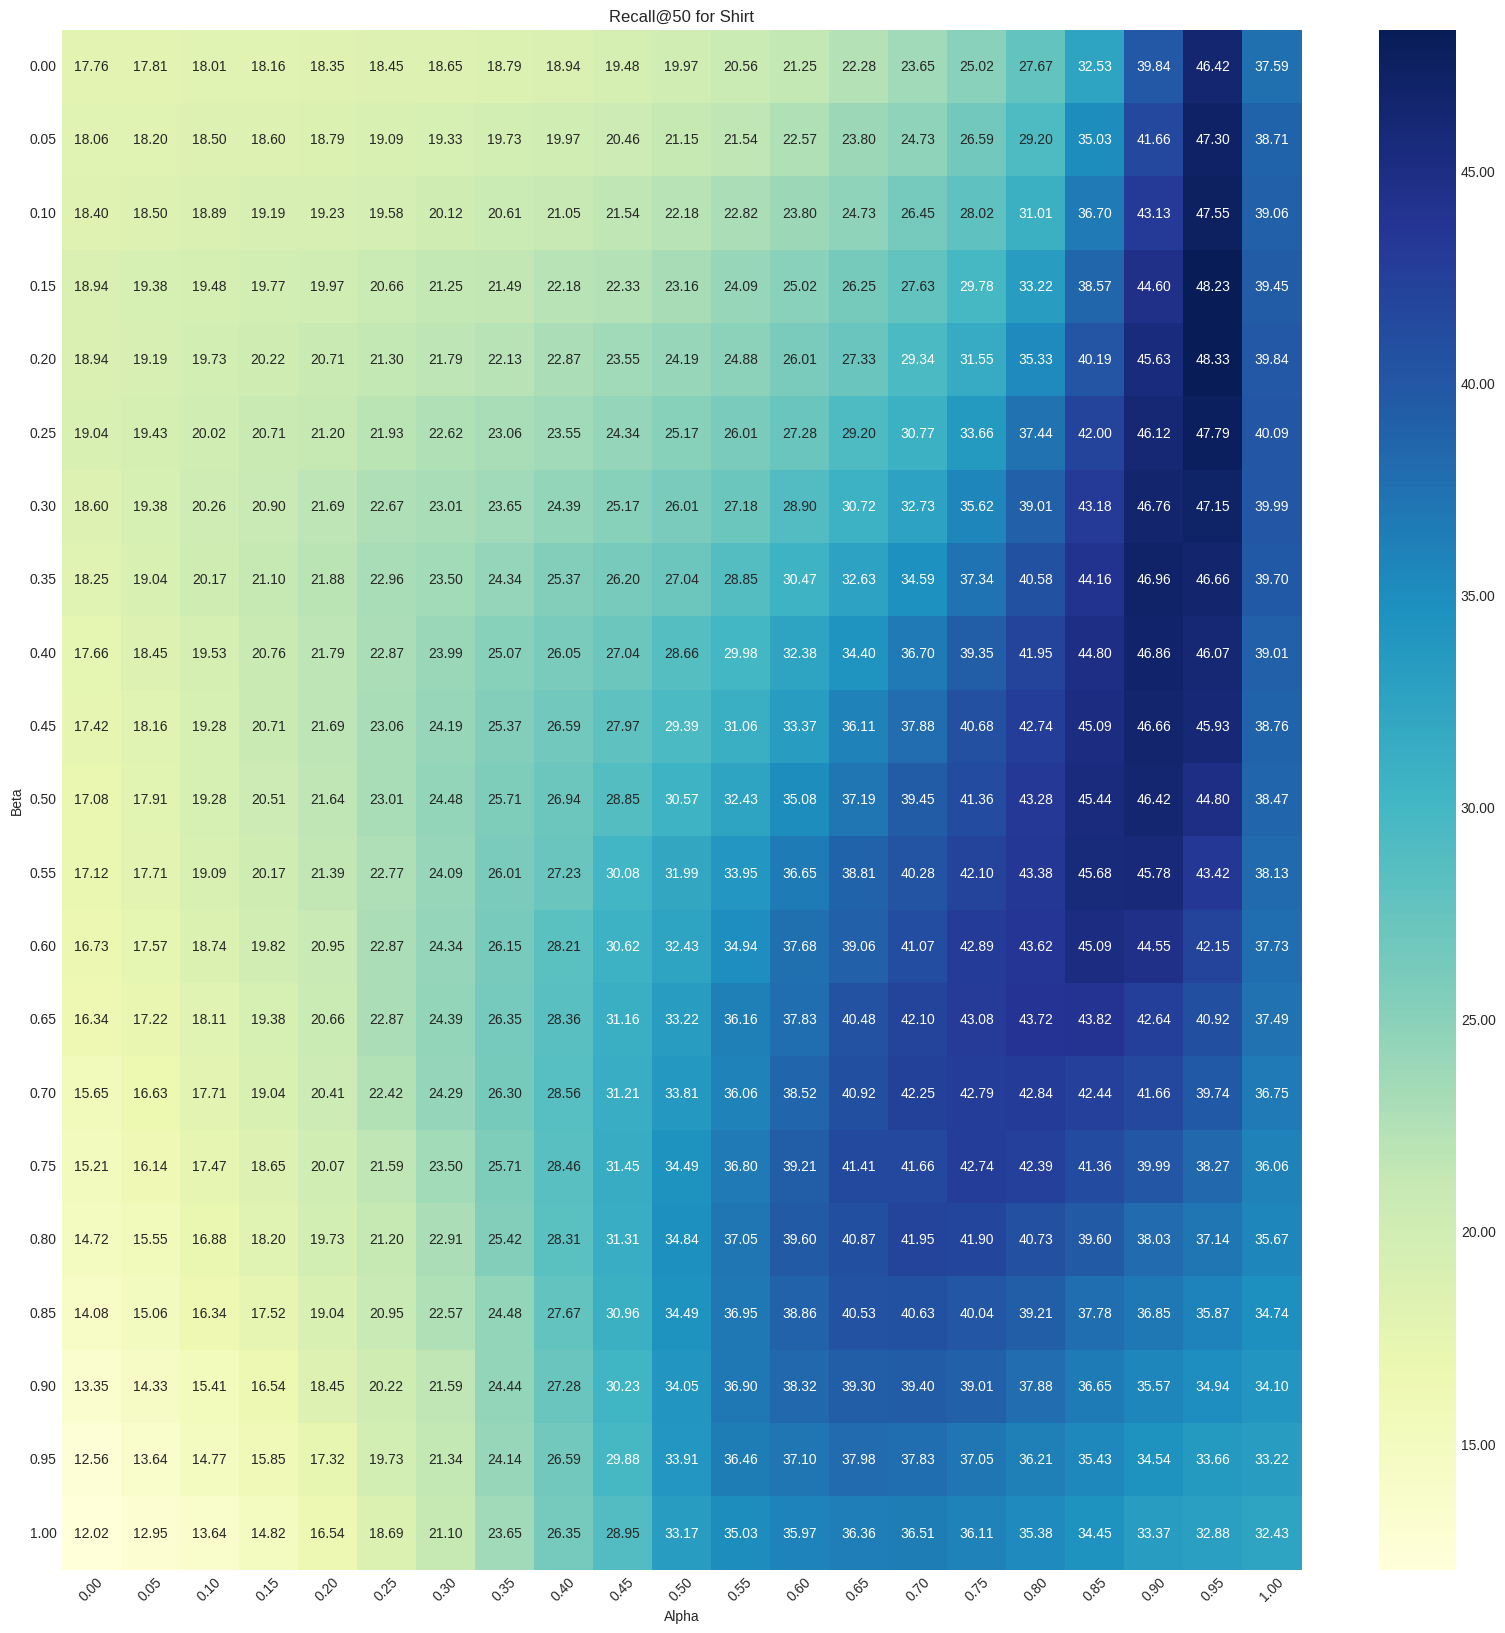

In [22]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

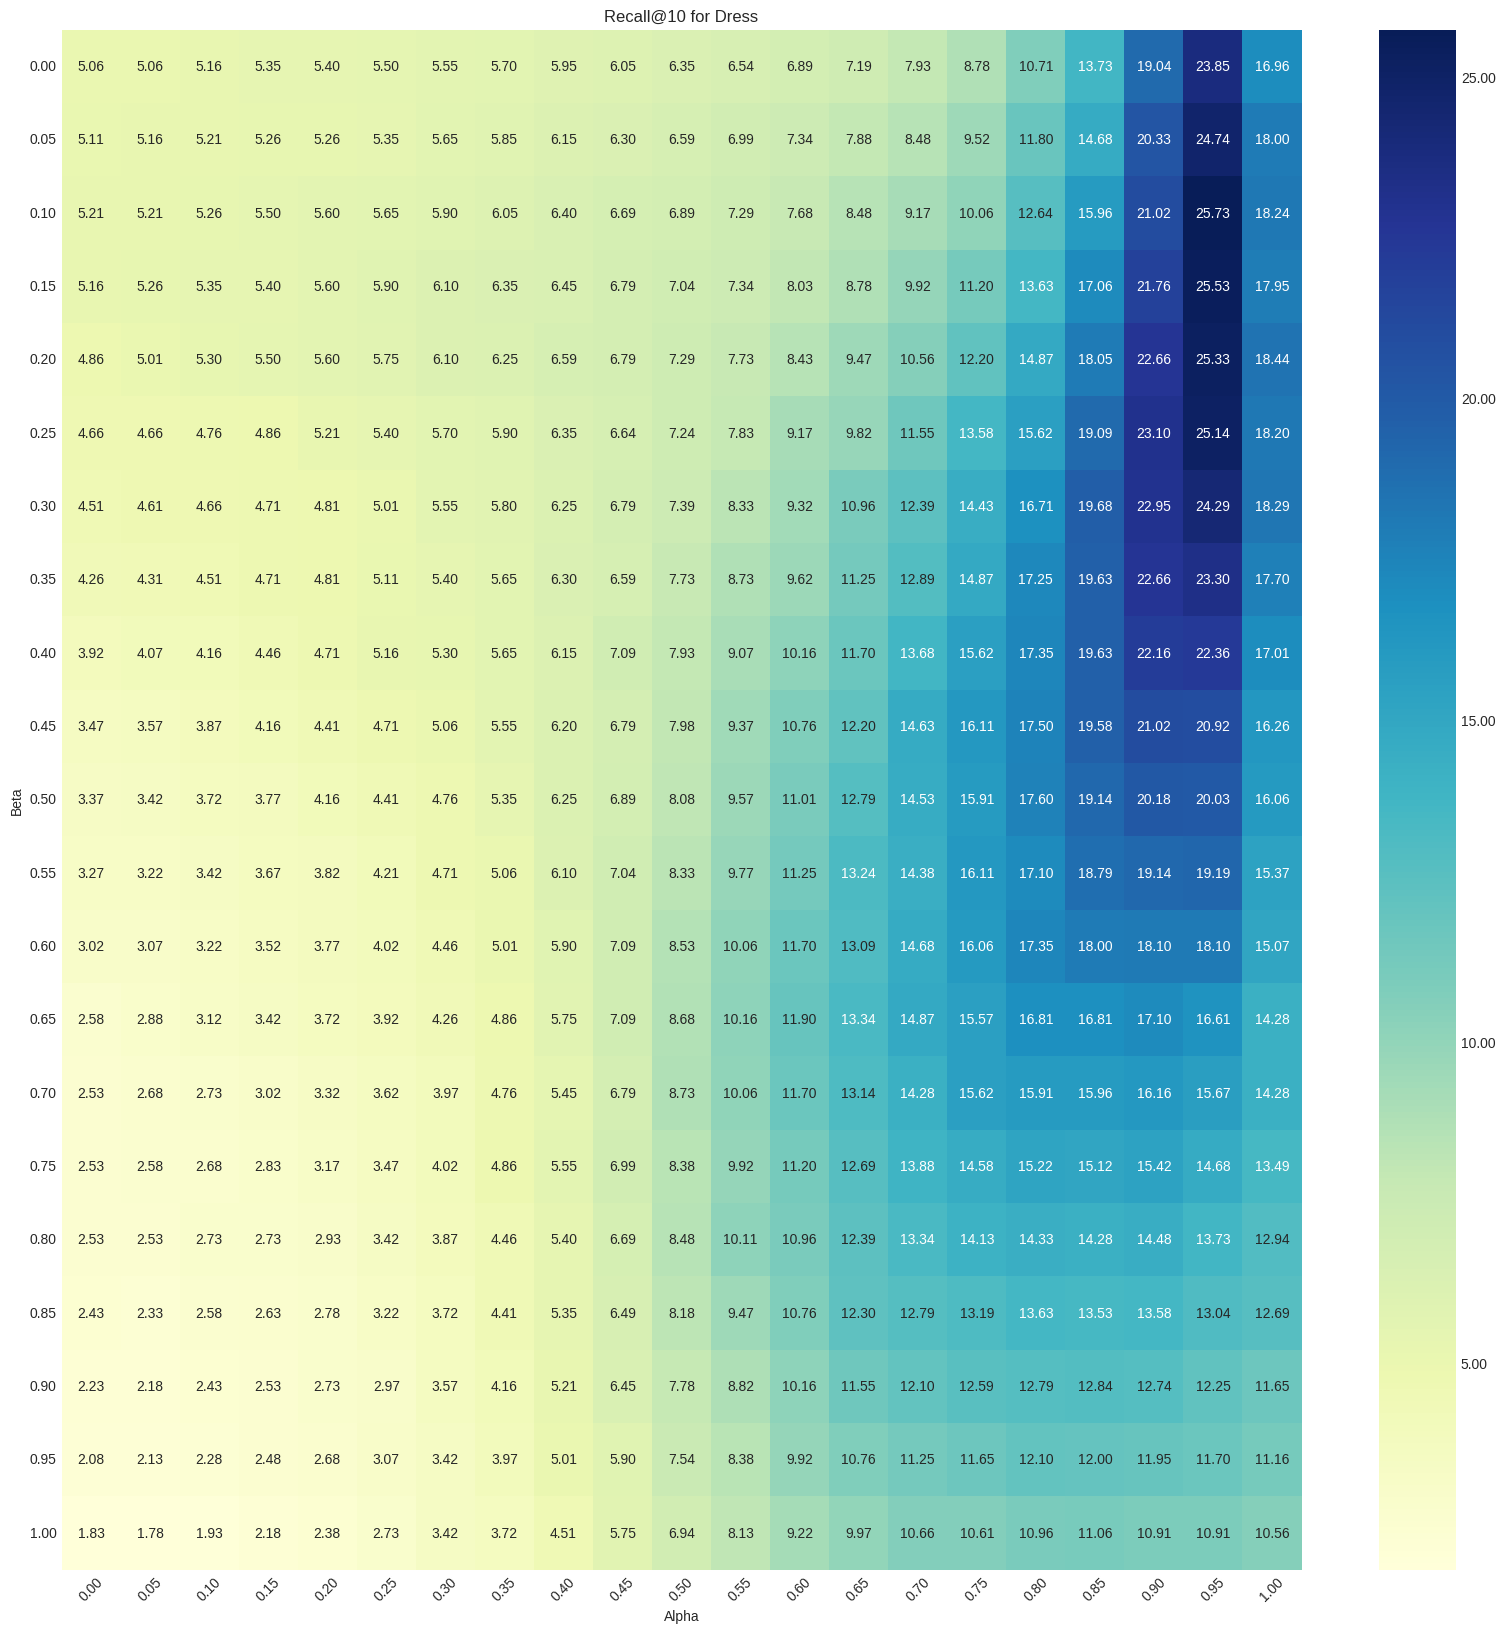

In [23]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

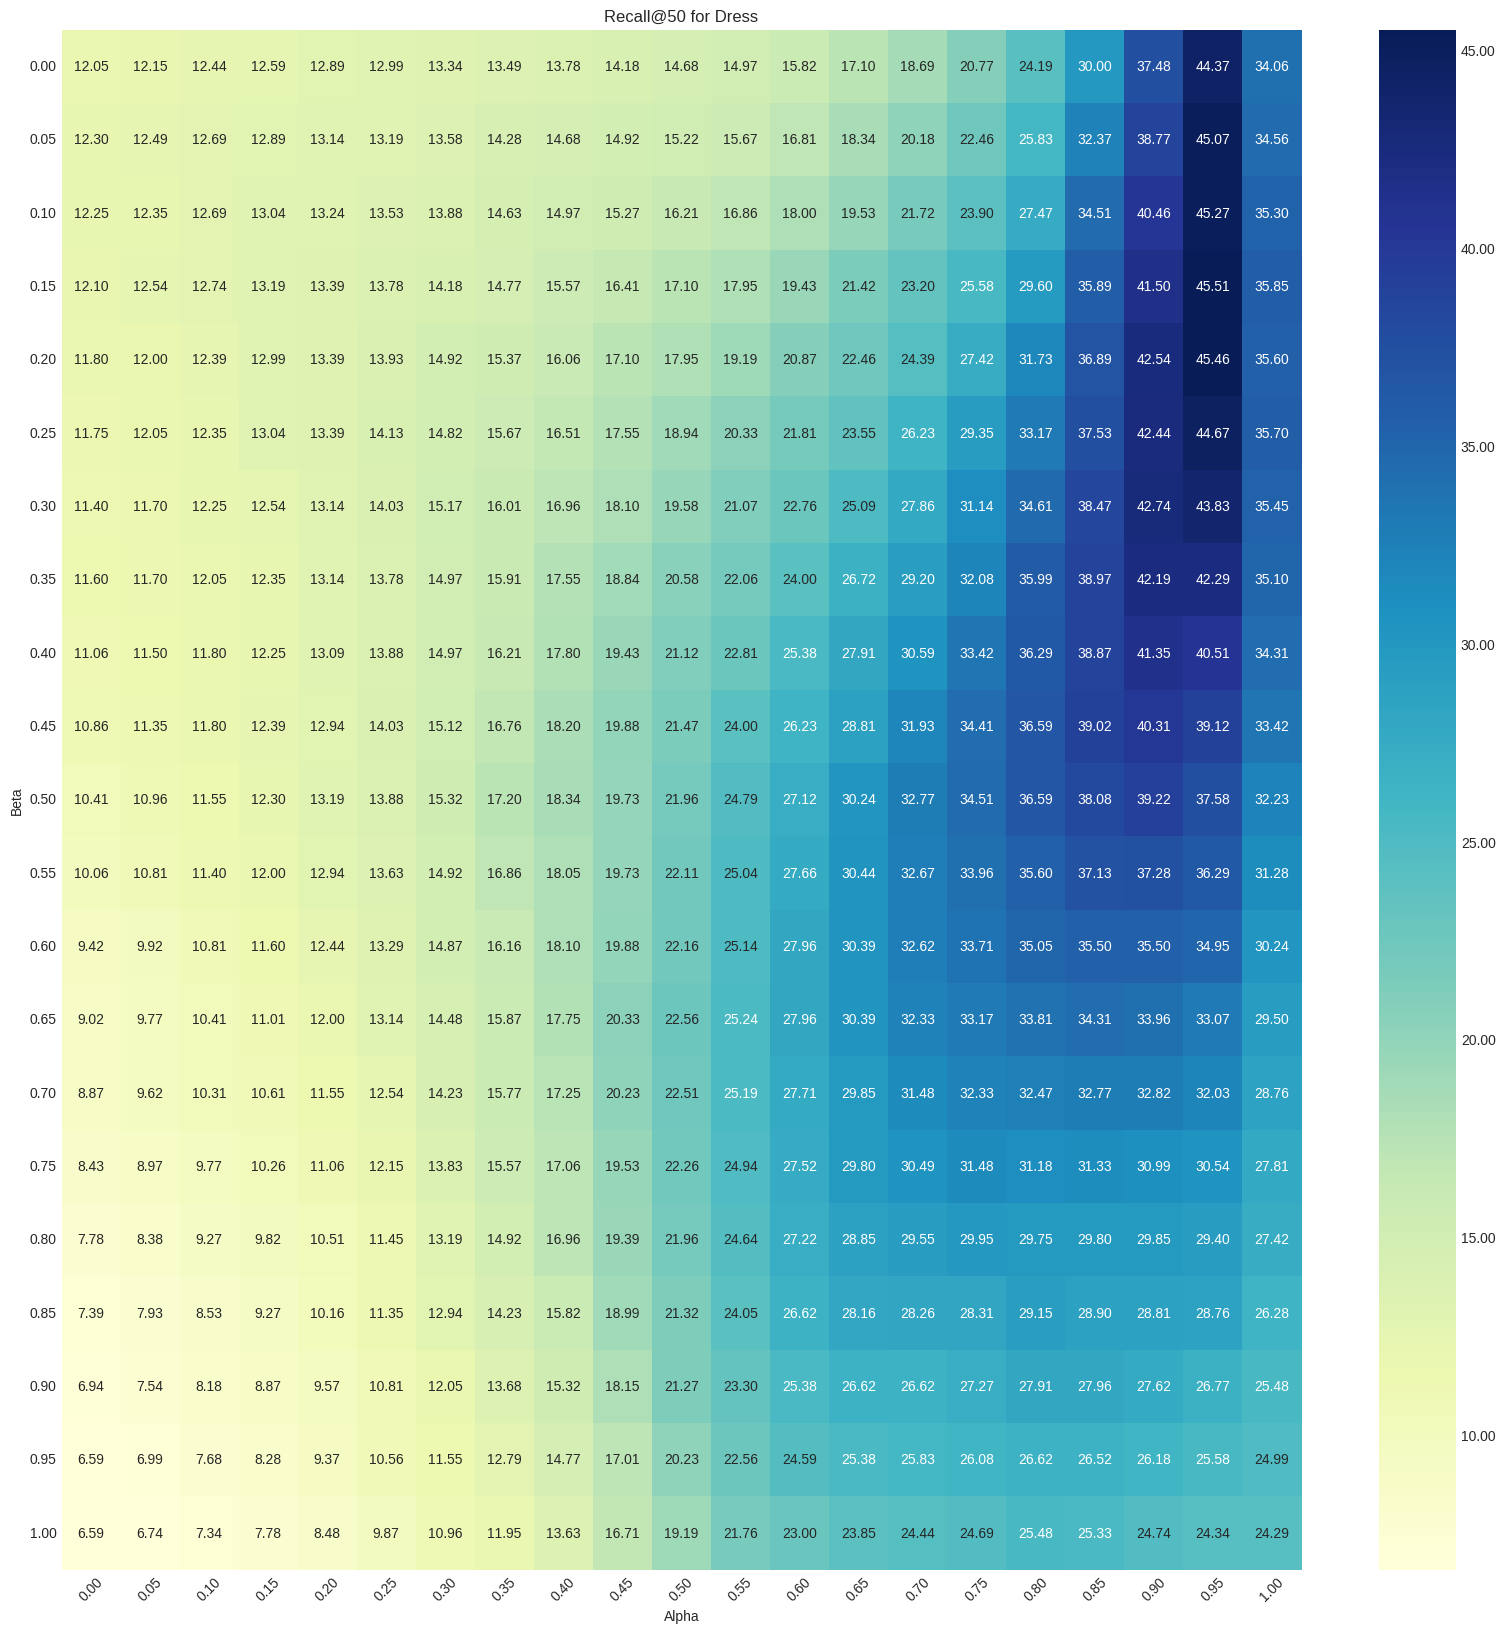

In [24]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

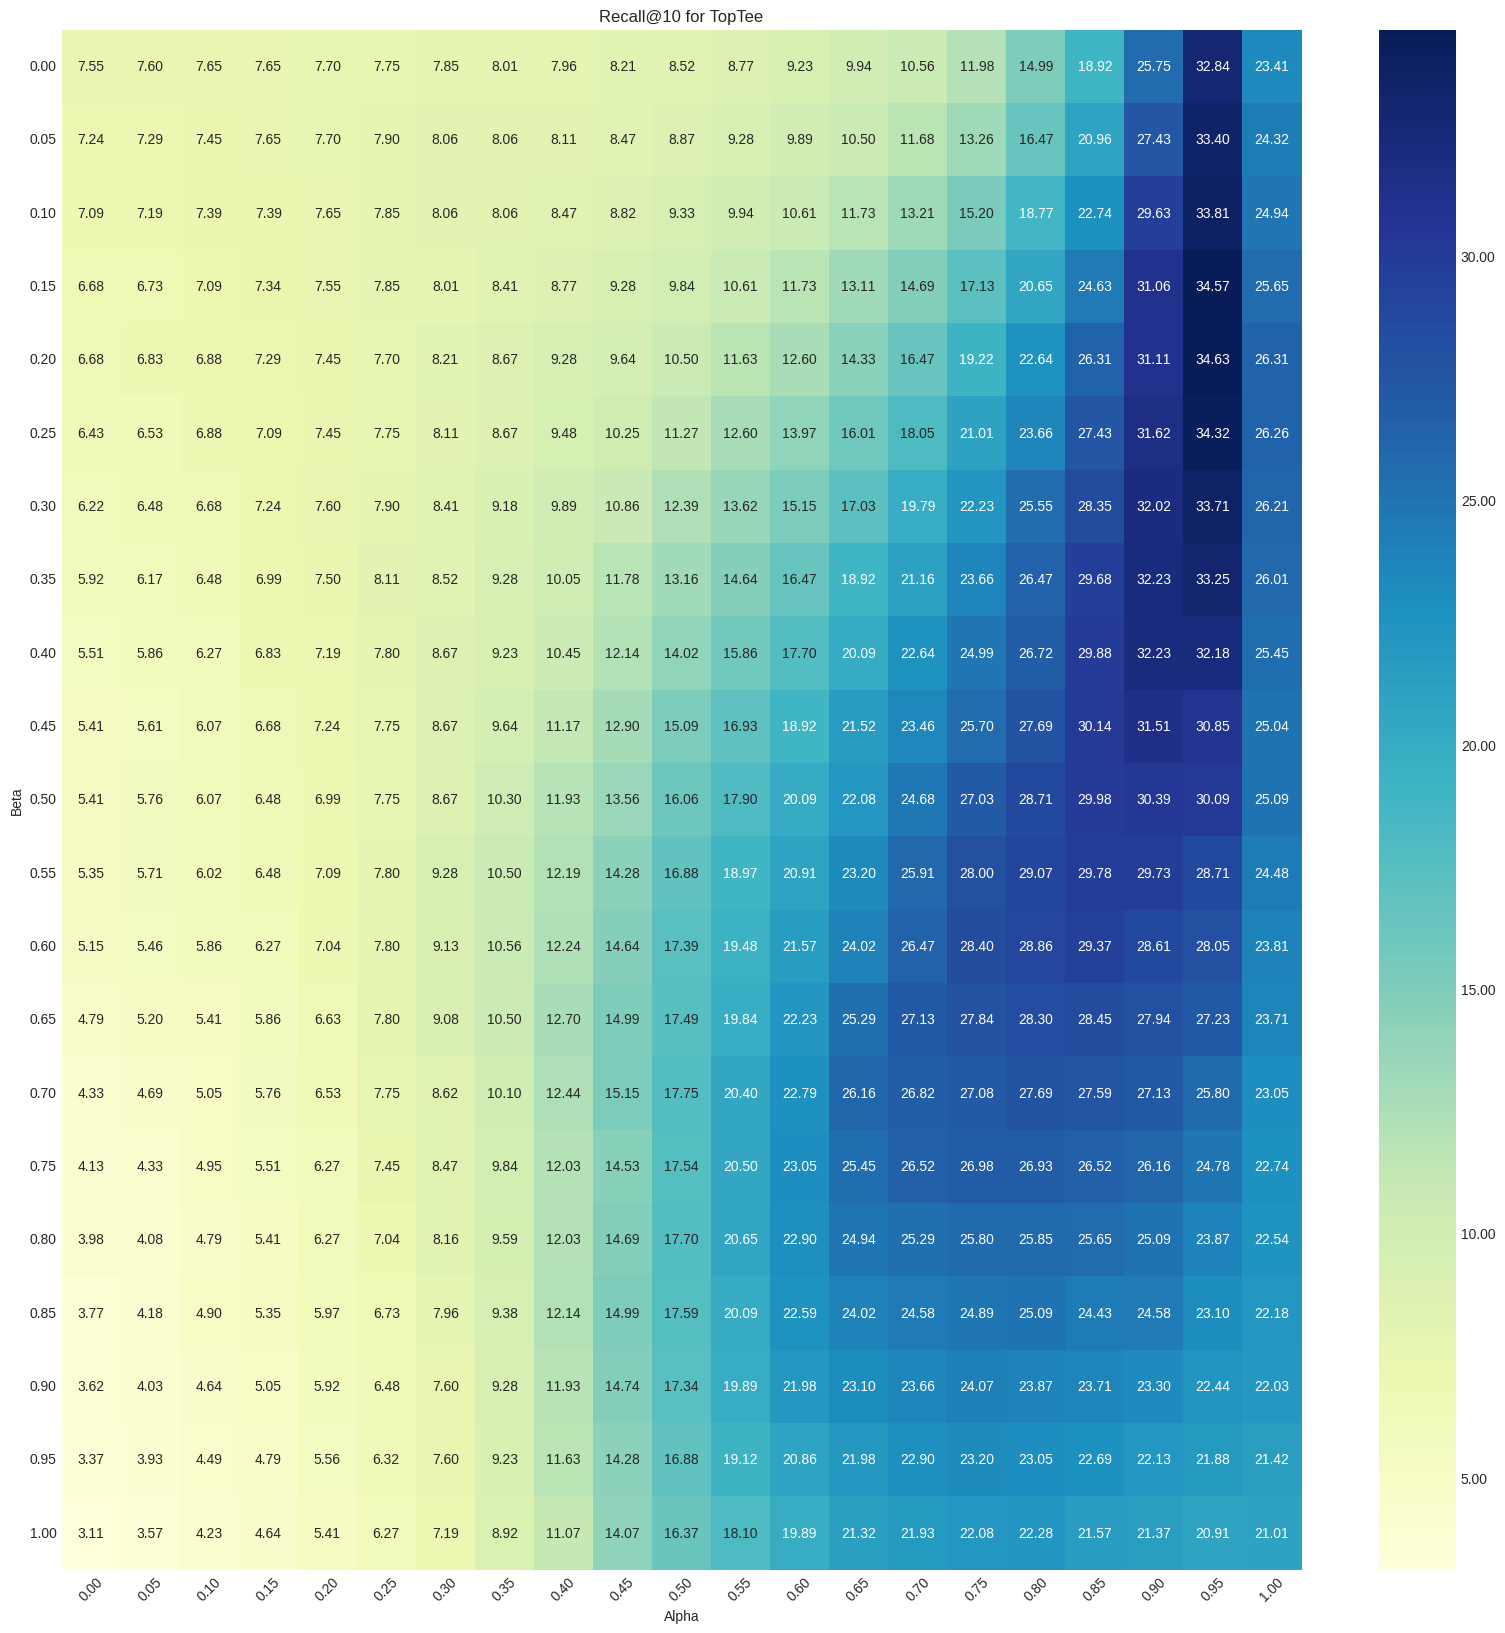

In [25]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

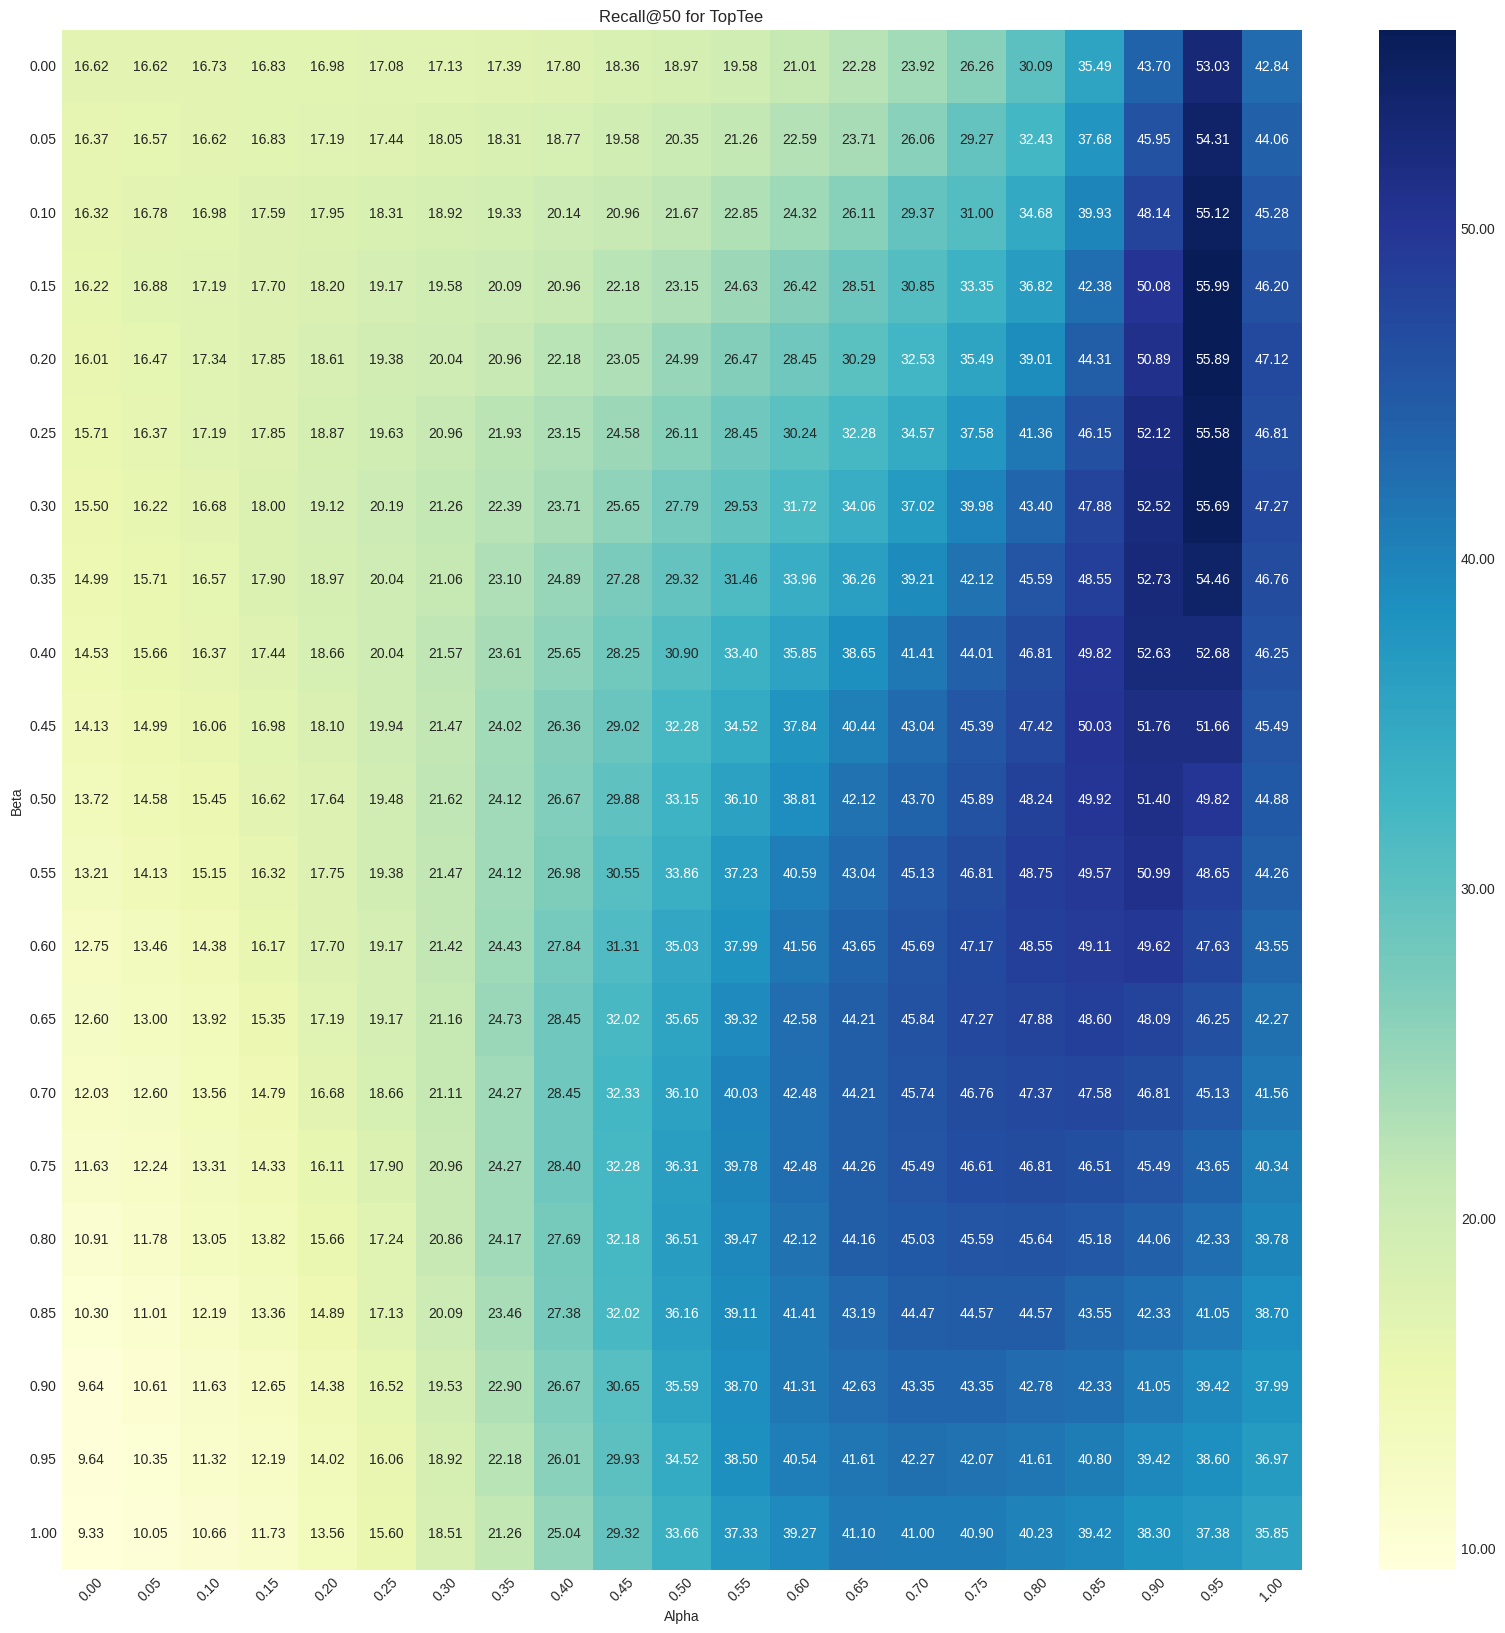

In [26]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

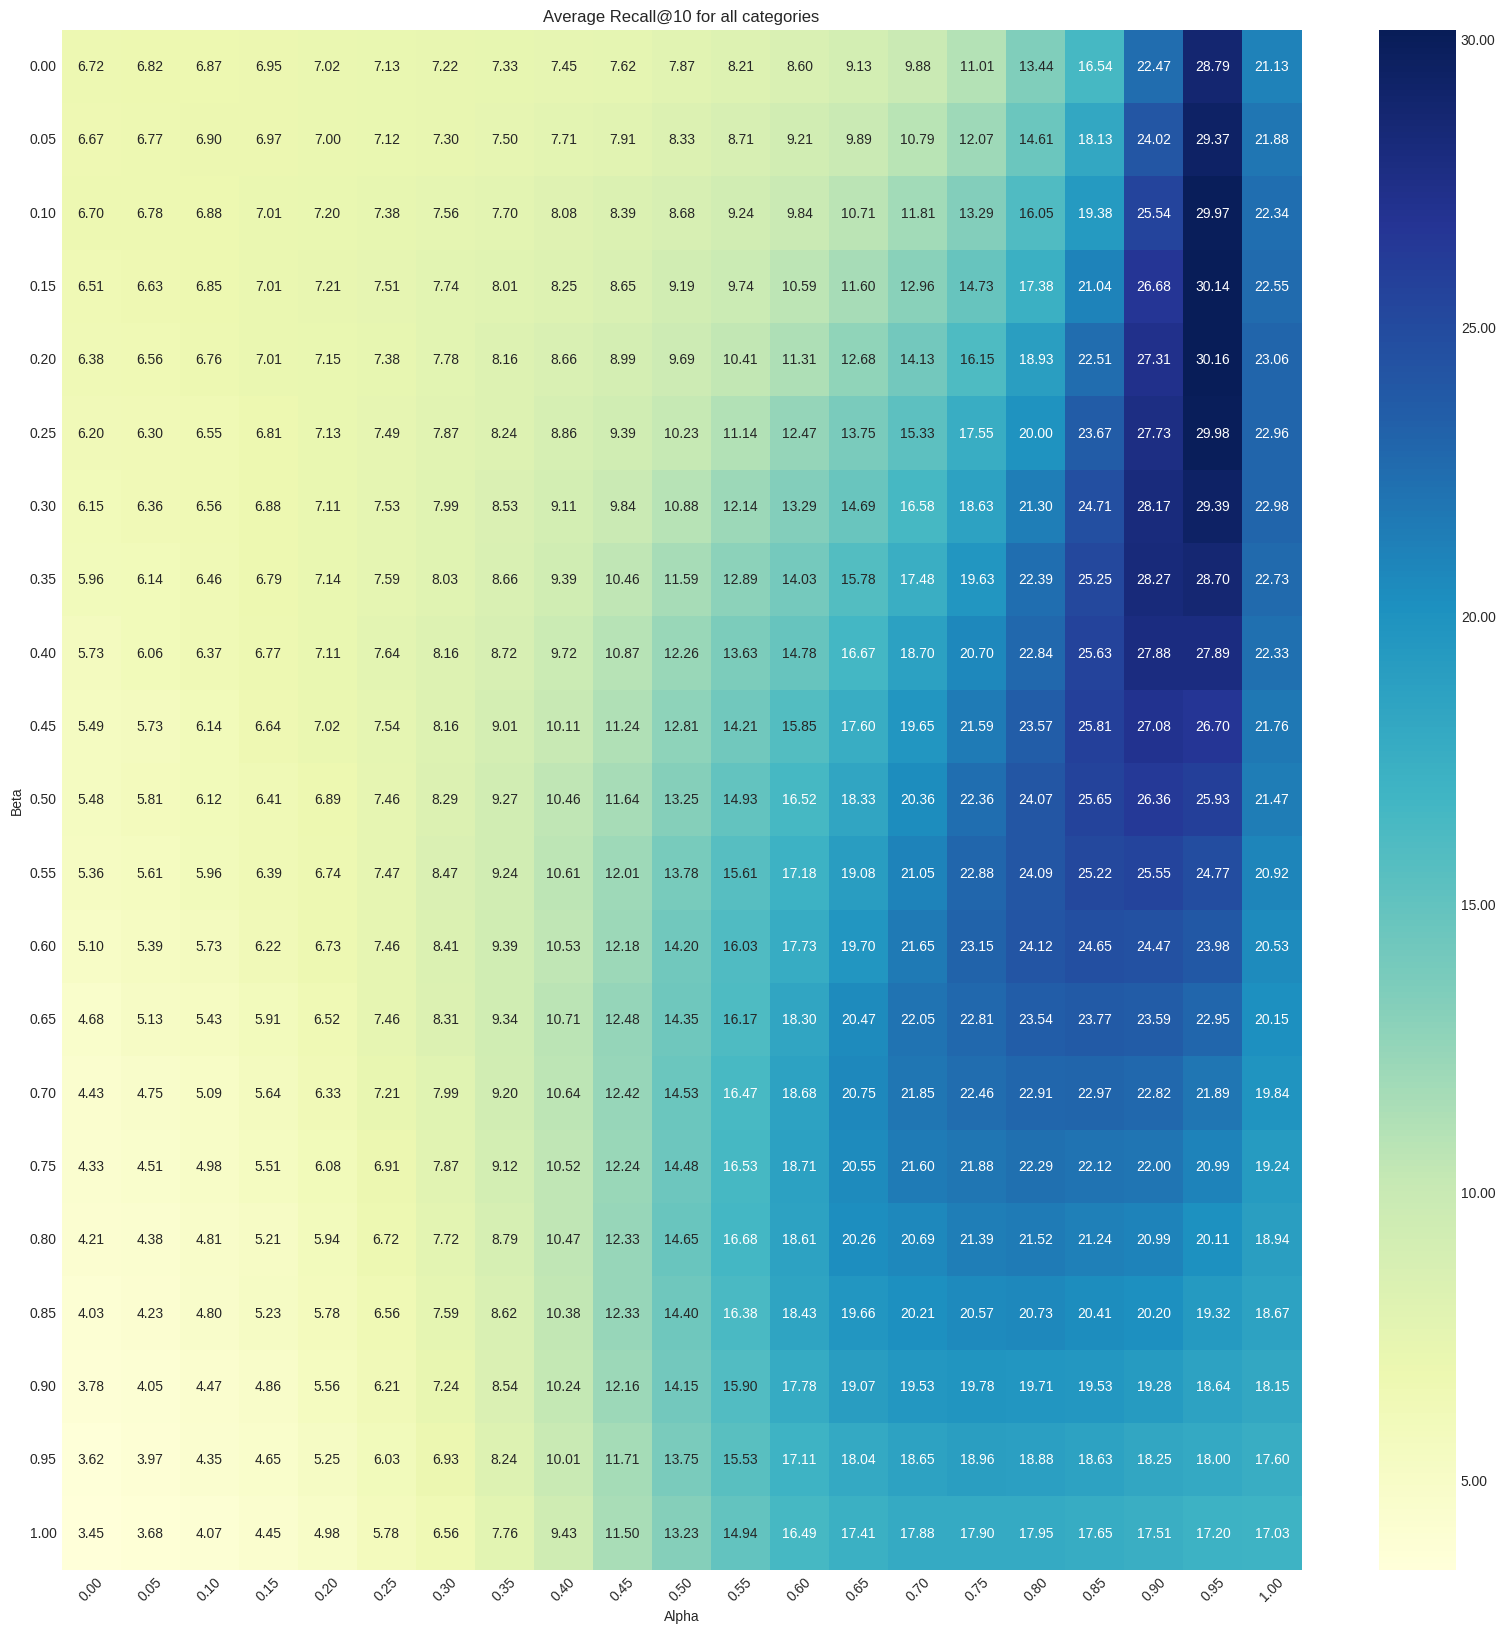

In [27]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

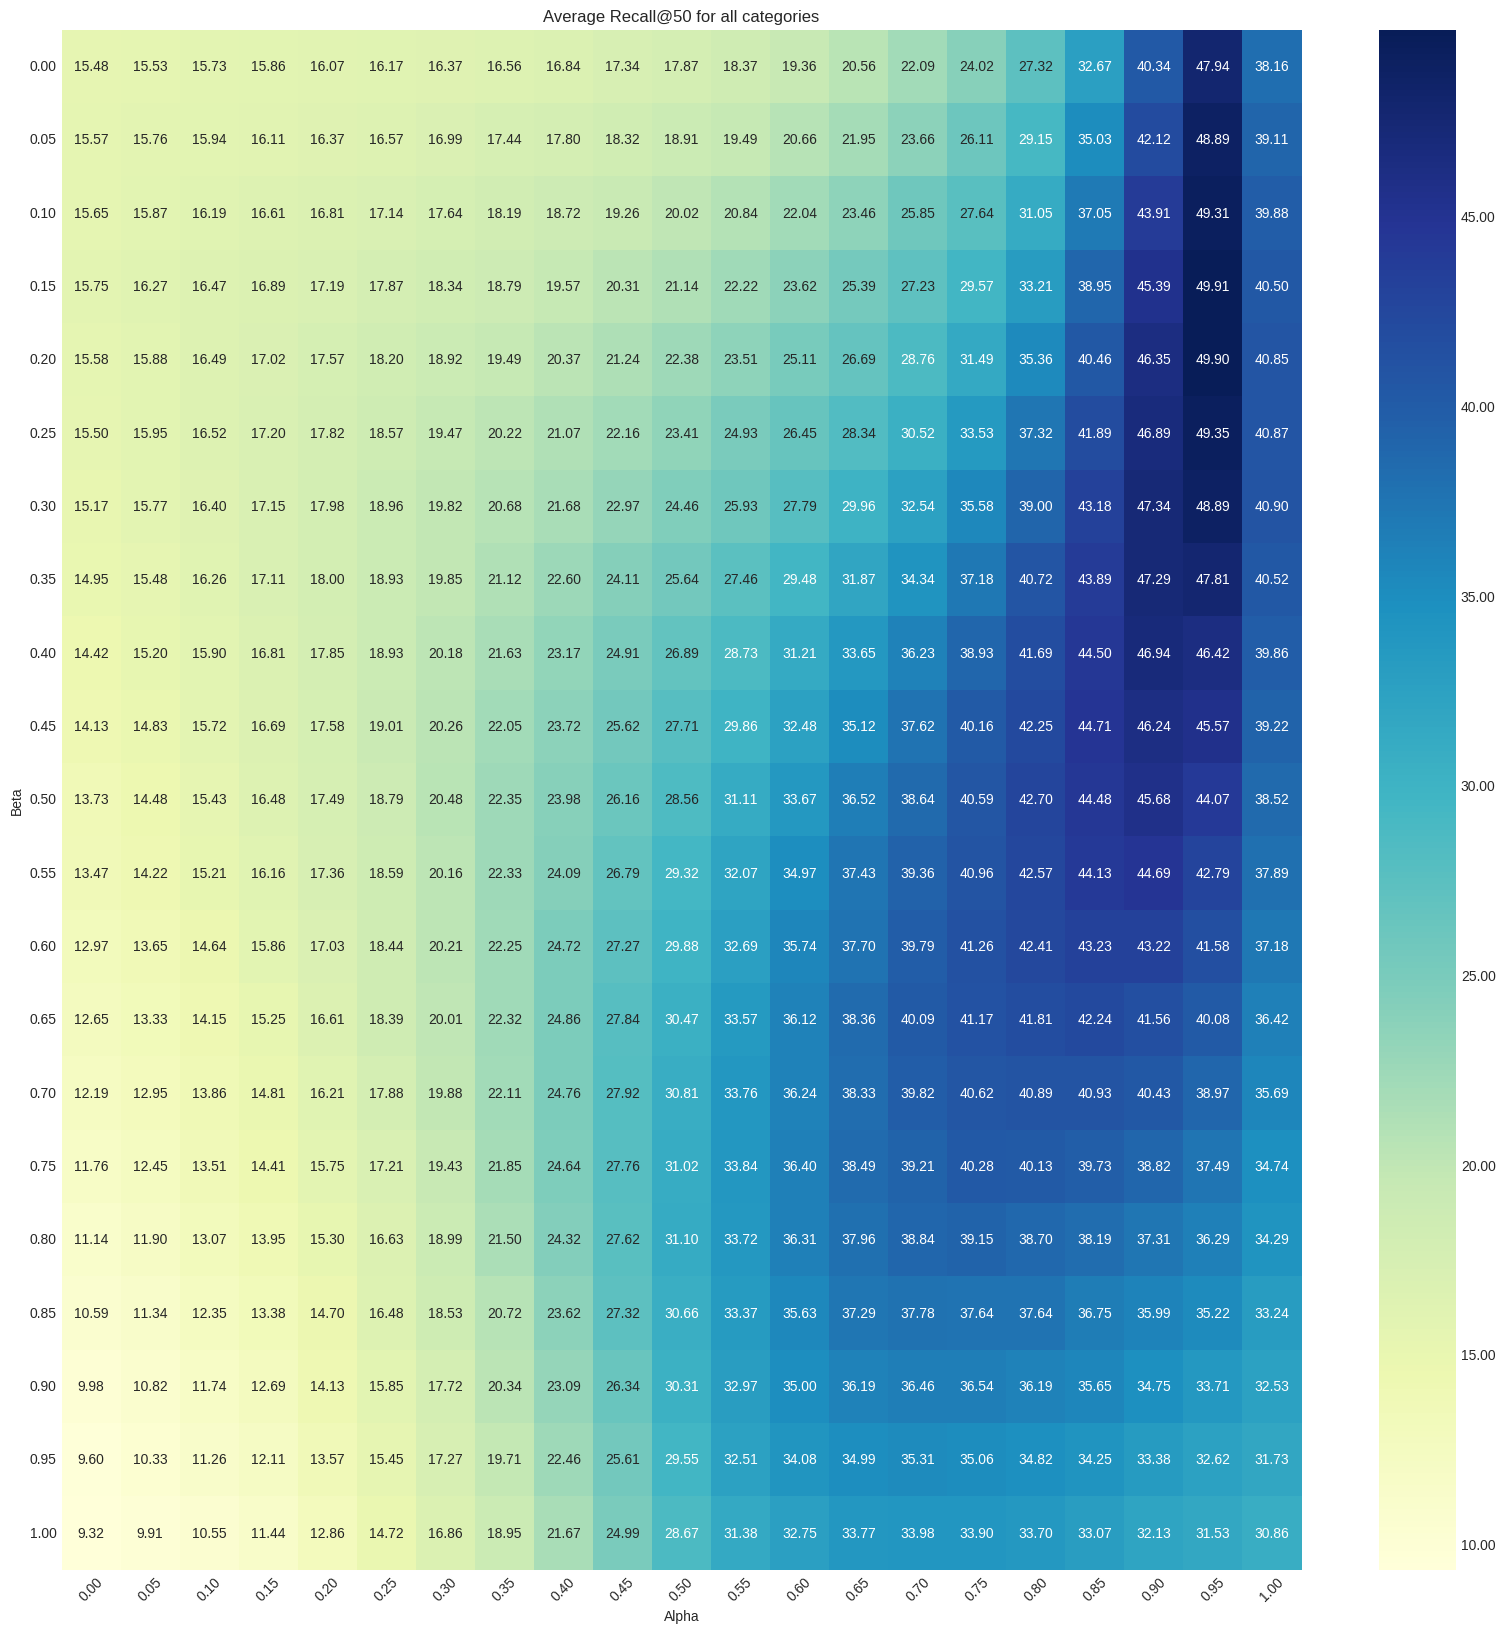

In [28]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [30]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val(
    'shirt',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 30.52011728286743
Recall at 50: 48.33169877529144


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [29]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val(
    'dress',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 25.334656238555908
Recall at 50: 45.46355903148651


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [31]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val(
    'toptee',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 34.6251904964447
Recall at 50: 55.88985085487366


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [32]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

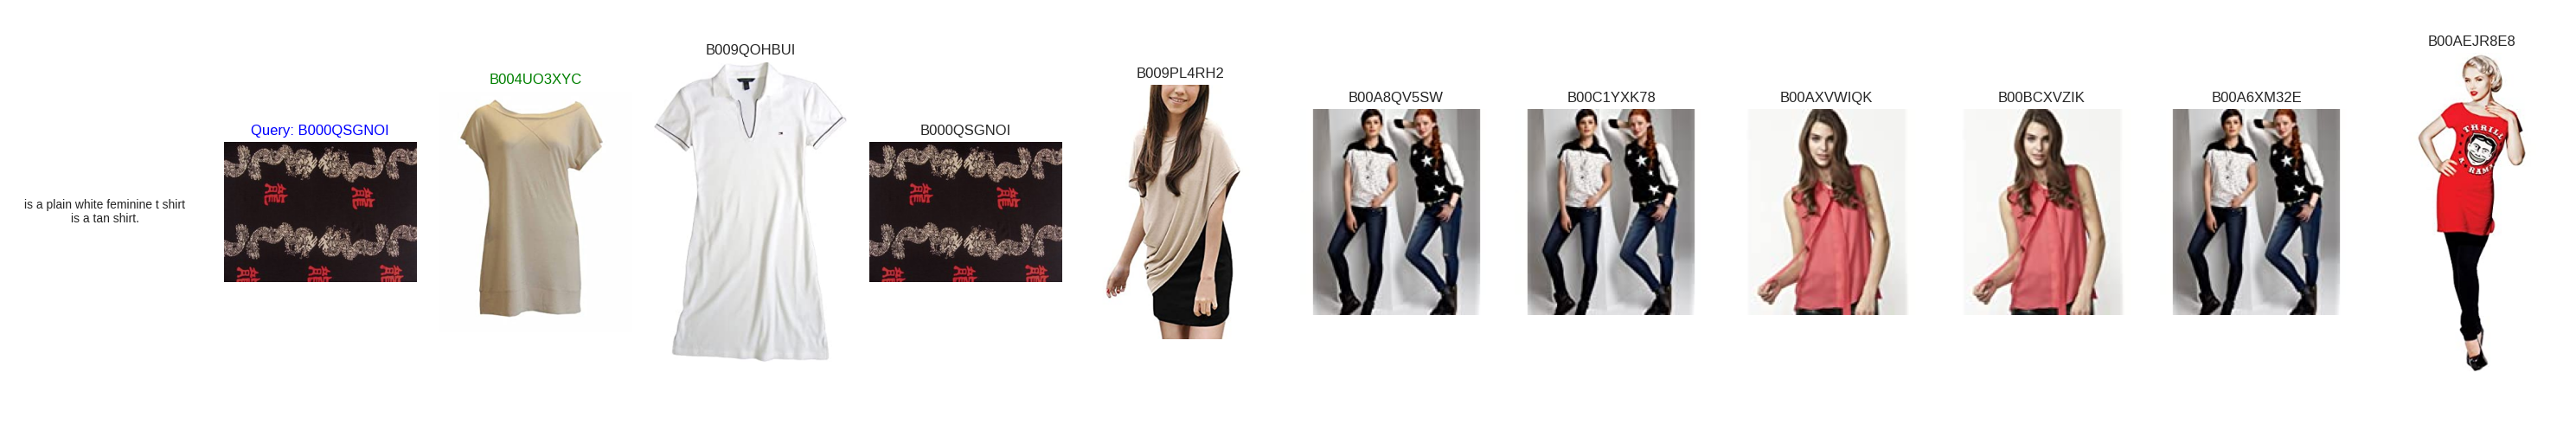

In [33]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [35]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 8.734052628278732
Recall at 50: 19.97056007385254


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [34]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 6.3460588455200195
Recall at 50: 14.675259590148926


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [36]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 8.516063541173935
Recall at 50: 18.969912827014923


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [39]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(520, [1, 6, 8, 11, 13, 16, 19, 20, 21, 24])

In [40]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(77, [10, 84, 117, 150, 183, 187, 195, 222, 258, 263])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [37]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(455, [0, 1, 3, 10, 11, 12, 16, 19, 27, 33])

In [38]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(54, [6, 13, 109, 169, 215, 218, 262, 352, 459, 496])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [41]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(582, [2, 4, 7, 9, 17, 18, 20, 24, 25, 28])

In [42]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(59, [32, 44, 101, 117, 128, 170, 176, 216, 230, 241])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

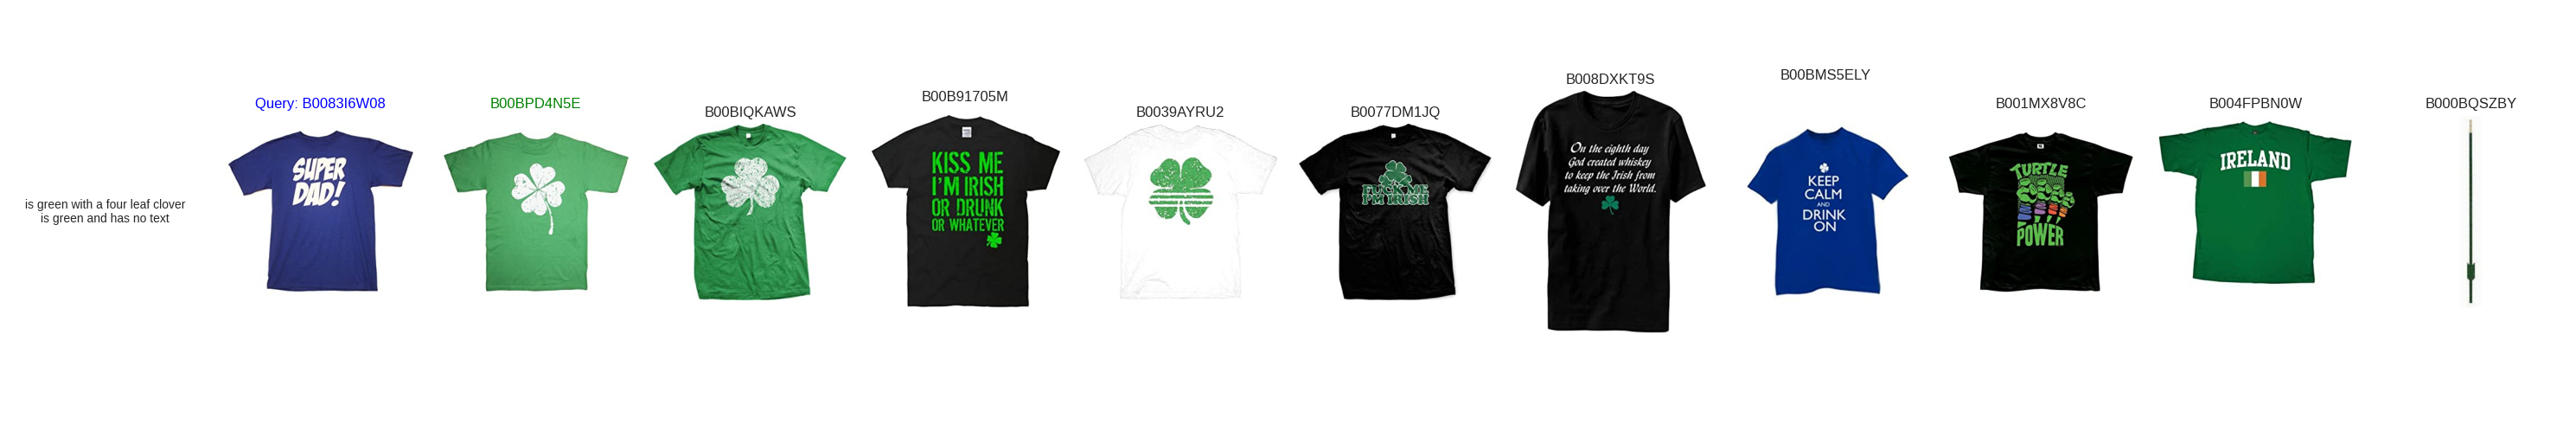

In [45]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

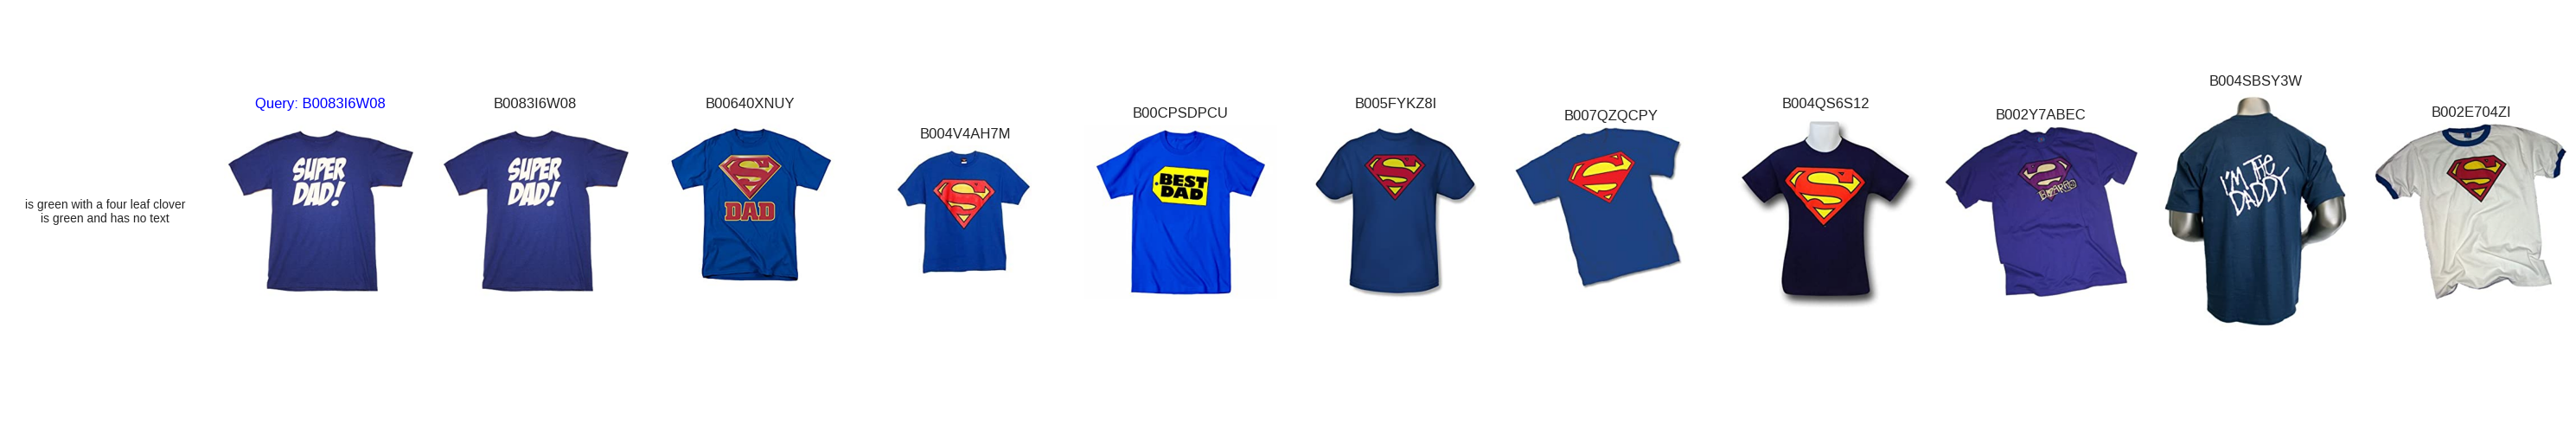

In [46]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

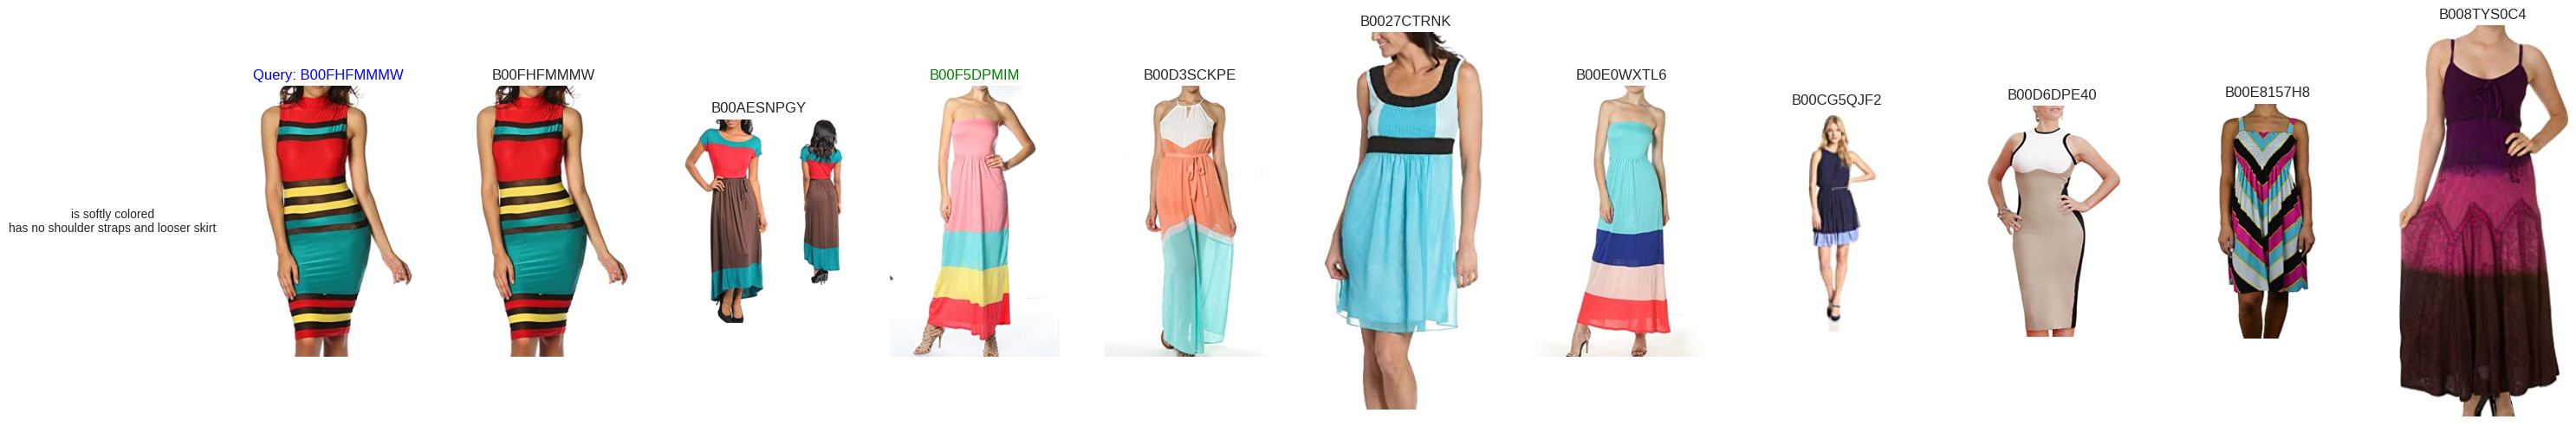

In [43]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

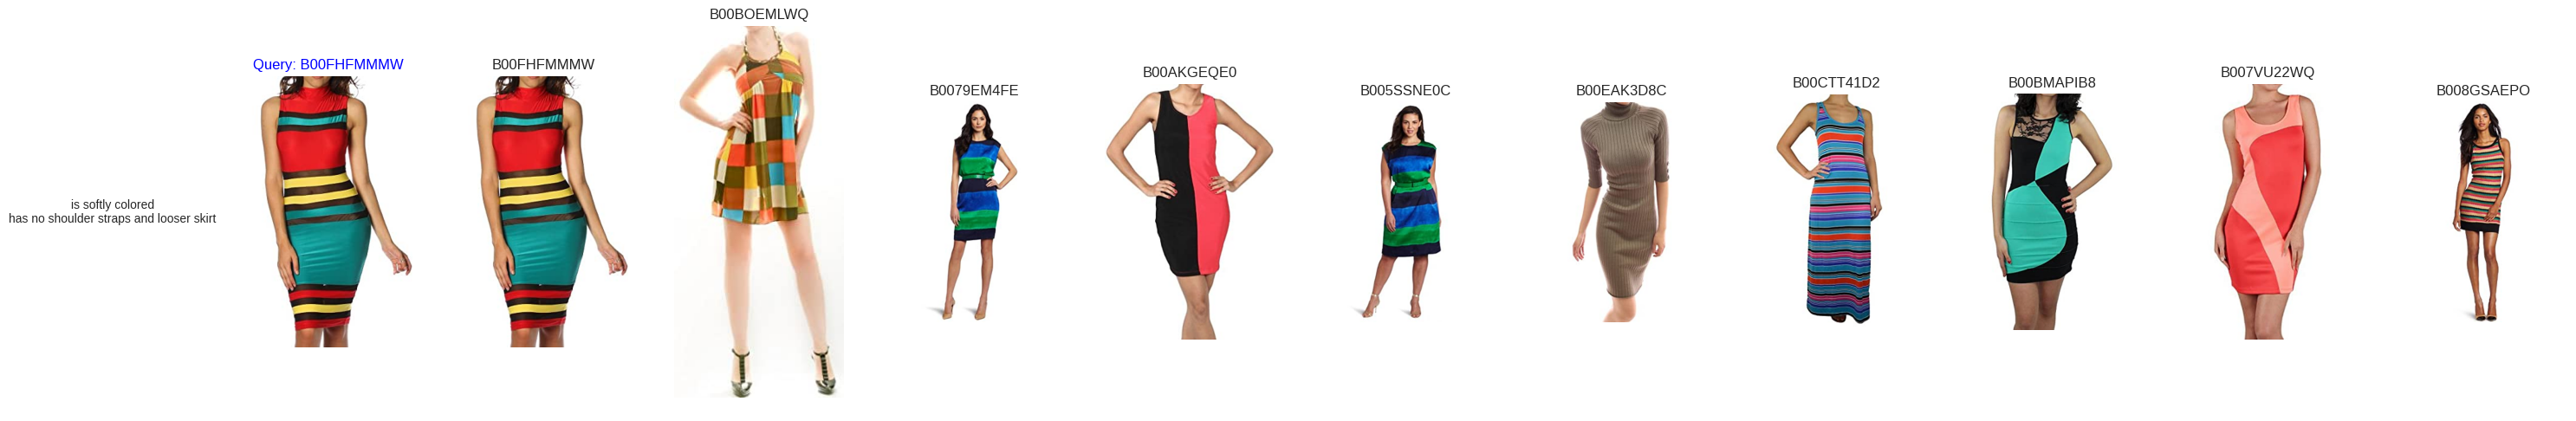

In [44]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

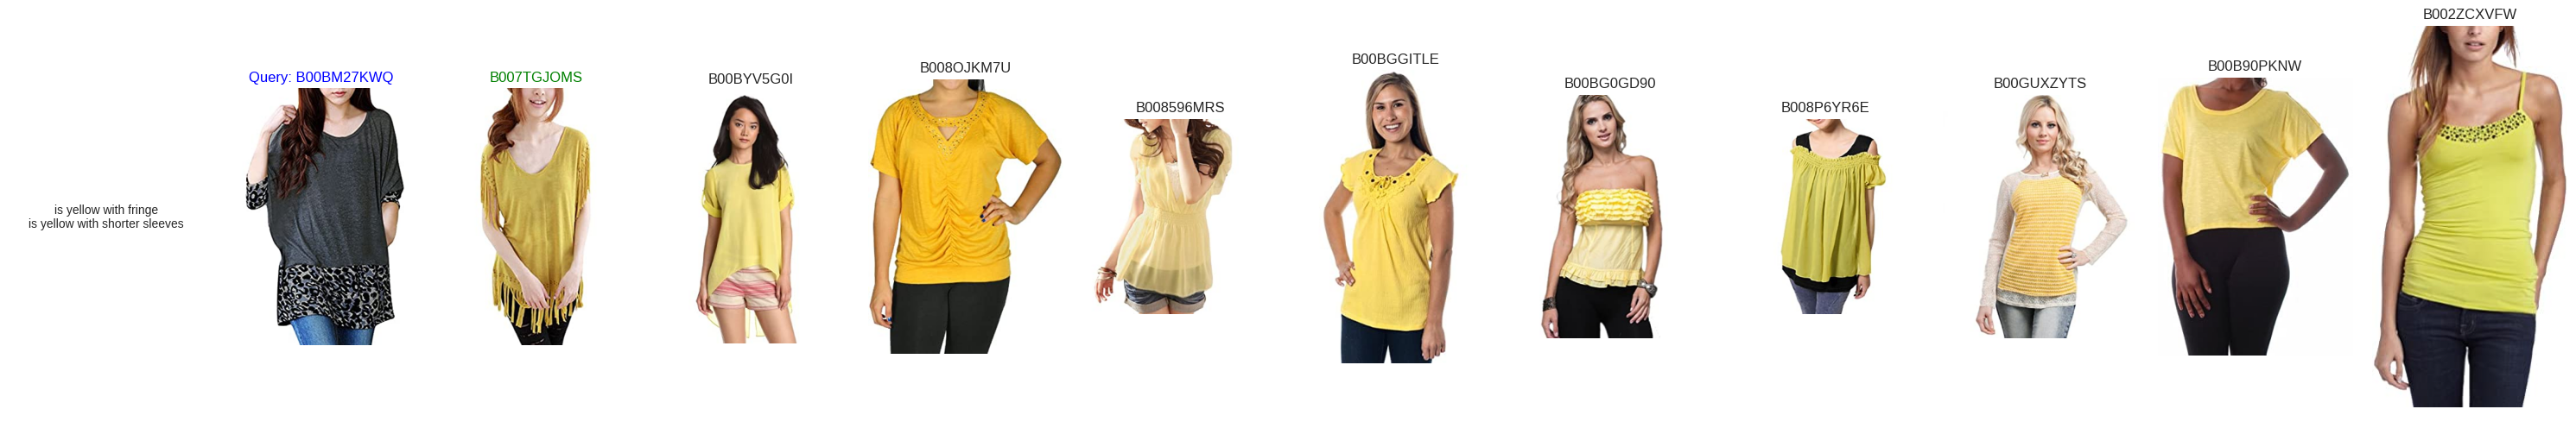

In [47]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

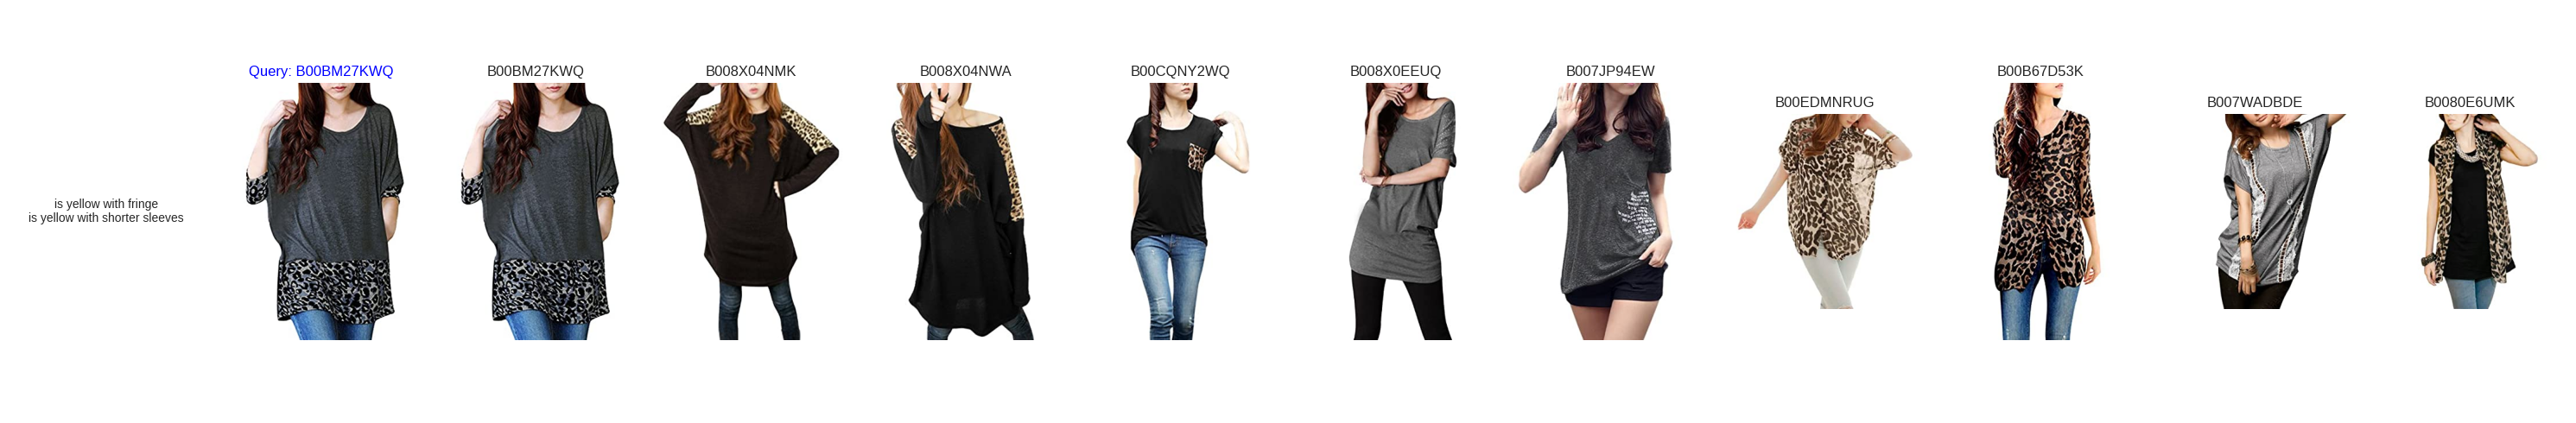

In [48]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)